# 라이브러리 임포트 및 데이터 로드?

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics.pairwise import cosine_similarity

font_path = '/System/Library/AssetsV2/com_apple_MobileAsset_Font7/bad9b4bf17cf1669dde54184ba4431c22dcad27b.asset/AssetData/NanumGothic.ttc'
fontprop = fm.FontProperties(fname = font_path, size = 10)
mpl.rcParams['axes.unicode_minus'] = False

In [3]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
submission = pd.read_csv("data/sample_submission.csv")

# 데이터 EDA

## test

In [4]:
test.head(1)

,ID,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,게재일
0,TEST_000,서류확인,223000000.0,530000,NaN,5.0,5.0,남향,1.0,1.0,불가능,NaN,7,Z86Th6S3K5,D플랫폼,2024-10-21


In [5]:
print("test 널데이터 수 :")
test.isna().sum()

test 널데이터 수 :


ID          0
매물확인방식      0
보증금         0
월세          0
전용면적      184
해당층        50
총층          2
방향          0
방수          2
욕실수         2
주차가능여부      0
총주차대수     175
관리비         0
중개사무소       0
제공플랫폼       0
게재일         0
dtype: int64

In [6]:
# 게재일별 빈도 계산
date_counts = test[['게재일', '월세']]  # 게재일 기준 정렬

date_counts

,게재일,월세
0,2024-10-21,530000
1,2023-09-02,590000
2,2024-04-03,200000
3,2024-09-19,250000
4,2024-11-10,380000
...,...,...
608,2024-09-24,340000
609,2024-09-04,750000
610,2024-04-20,500000
611,2024-11-17,340000


In [7]:
date_counts['게재일'] = pd.to_datetime(date_counts['게재일'])
date_counts["게재월"] = date_counts["게재일"].dt.to_period("M")
date_counts["게재분기"] = date_counts["게재일"].dt.to_period("Q")

test_Q_counts= date_counts["게재분기"].value_counts()
test_M_counts= date_counts["게재월"].value_counts()

test_Q_counts.index = test_Q_counts.index.astype(str)
test_M_counts.index = test_M_counts.index.astype(str)

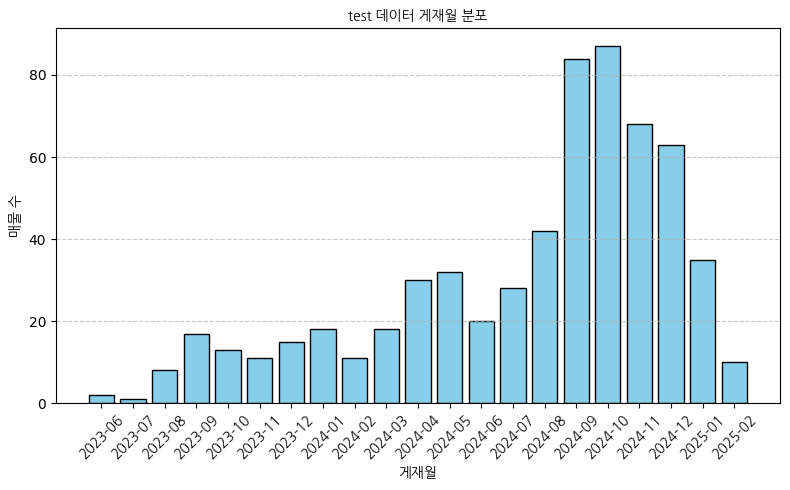

In [8]:
# 게재월 인덱스를 정수형으로 변환 후 정렬
test_M_counts_sorted = test_M_counts.sort_index()

plt.figure(figsize=(8, 5))
plt.bar(test_M_counts_sorted.index, test_M_counts_sorted.values, color='skyblue', edgecolor="k")
plt.title("test 데이터 게재월 분포", fontsize=12, fontproperties=fontprop)
plt.xlabel("게재월", fontsize=10, fontproperties=fontprop)
plt.ylabel("매물 수", fontsize=10, fontproperties=fontprop)
plt.grid(True, axis="y", linestyle="--", alpha=0.7)  # Y축에만 점선 그리드 추가
plt.xticks(rotation=45, fontproperties=fontprop)
plt.tight_layout()
plt.show()

In [9]:
import matplotlib.pyplot as plt

# 허위 매물(`is_fake == 1`)만 필터링
fake_listings_train = train[train["허위매물여부"] == 1]

# 게재월별 매물 개수 집계
fake_M_counts_train = fake_listings_train["게재월"].value_counts()

# 게재월을 정렬 (문자열 '1월', '2월' 등의 형식이면 숫자로 변환 후 정렬)
fake_M_counts_train_sorted = fake_M_counts_train.reindex(
    sorted(fake_M_counts_train.index, key=lambda x: int(x.replace("월", "")))
)

# 시각화
plt.figure(figsize=(8, 5))
plt.bar(fake_M_counts_train_sorted.index, fake_M_counts_train_sorted.values, color='salmon', edgecolor="k")
plt.title("Train 데이터 허위 매물 게재월 분포", fontsize=12, fontproperties=fontprop)
plt.xlabel("게재월", fontsize=10, fontproperties=fontprop)
plt.ylabel("매물 수", fontsize=10, fontproperties=fontprop)
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.xticks(rotation=45, fontproperties=fontprop)
plt.tight_layout()
plt.show()

KeyError: '게재월'

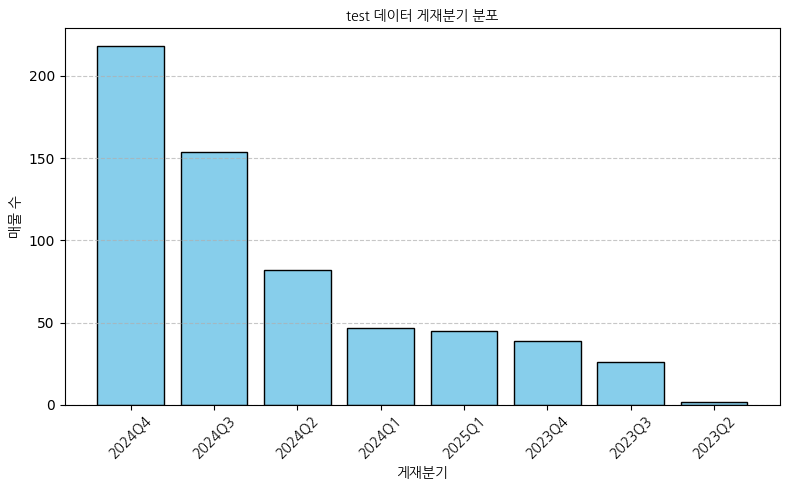

In [19]:
# 게재분기 분포 시각화
plt.figure(figsize=(8, 5))
plt.bar(test_Q_counts.index, test_Q_counts.values, color='skyblue', edgecolor="k")
plt.title("test 데이터 게재분기 분포", fontsize=12, fontproperties=fontprop)
plt.xlabel("게재분기", fontsize=10, fontproperties=fontprop)
plt.ylabel("매물 수", fontsize=10, fontproperties=fontprop)
plt.grid(True, axis="y", linestyle="--", alpha=0.7)  # Y축에만 점선 그리드 추가
plt.xticks(rotation=45, fontproperties=fontprop)
plt.tight_layout()
plt.show()

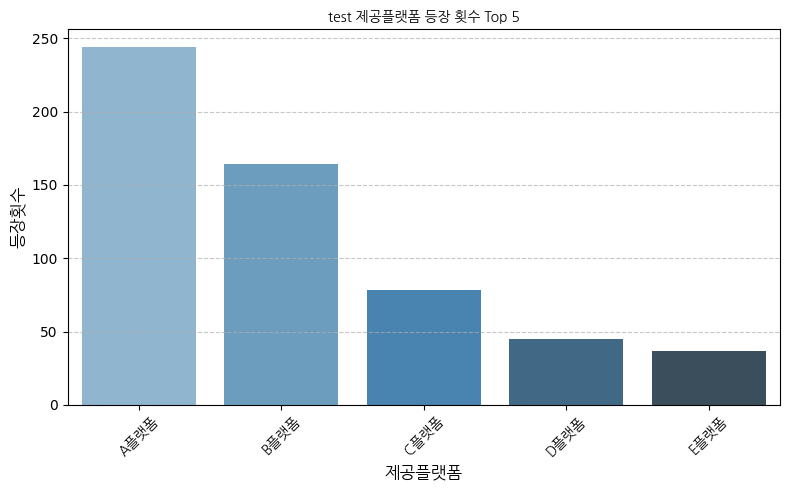

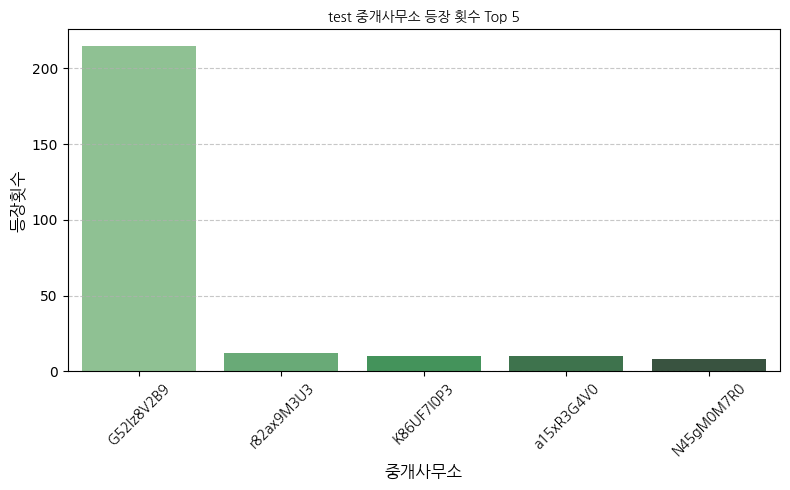

In [20]:
platform_counts = test['제공플랫폼'].value_counts()
office_counts = test['중개사무소'].value_counts()

top5_data = {
    "제공플랫폼": platform_counts.nlargest(5),  # 열 이름 제거
    "중개사무소": office_counts.nlargest(5)    # 열 이름 제거
}

palette = {"제공플랫폼": "Blues_d", "중개사무소": "Greens_d"}

for col, data in top5_data.items():
    plt.figure(figsize=(8, 5))
    sns.barplot(x=data.index, y=data.values, palette=palette[col])
    plt.title(f"test {col} 등장 횟수 Top 5", fontsize=14, fontproperties=fontprop)
    plt.xlabel(col, fontsize=12, fontproperties=fontprop)
    plt.ylabel("등장횟수", fontsize=12, fontproperties=fontprop)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45, fontproperties=fontprop)
    plt.tight_layout()
    plt.show()

**Test 기준**
- 플랫폼 : 'A플랫폼'이 약 1000개로 다수의 매물을 보유중
    - A플랫폼 역시 G52Iz8V2B9의 매물을 78개 보유중 (다음 다수는 10개)
- 중개사무소 : 'G52Iz8V2B9' 이라는 중개사무소가 약 800개의 매물을 보유중
    - G52Iz8V2B9는 플랫폼 H, K, N을 제외한 다른 플랫폼에 최소 2개부터 최대 78개까지 매물을 보유중 -> 되게 큰 중개사무소 인 듯 함
    - G52Iz8V2B9가 다루는 매물의 총층수는 최소 2층에서 최대 21층까지 다양함.
        - 그 중에서 가장 상위권은 6,15,14,4,8,5층

## train

### 기초 통계량

In [10]:
train.head(1)

,ID,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,게재일,허위매물여부
0,TRAIN_0000,현장확인,402500000.0,470000,NaN,NaN,15.0,서향,1.0,1.0,가능,40.0,96,t93Nt6I2I0,B플랫폼,2024-10-09,0


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452 entries, 0 to 2451
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      2452 non-null   object 
 1   매물확인방식  2452 non-null   object 
 2   보증금     2452 non-null   float64
 3   월세      2452 non-null   int64  
 4   전용면적    1665 non-null   float64
 5   해당층     2223 non-null   float64
 6   총층      2436 non-null   float64
 7   방향      2452 non-null   object 
 8   방수      2436 non-null   float64
 9   욕실수     2434 non-null   float64
 10  주차가능여부  2452 non-null   object 
 11  총주차대수   1756 non-null   float64
 12  관리비     2452 non-null   int64  
 13  중개사무소   2452 non-null   object 
 14  제공플랫폼   2452 non-null   object 
 15  게재일     2452 non-null   object 
 16  허위매물여부  2452 non-null   int64  
dtypes: float64(7), int64(3), object(7)
memory usage: 325.8+ KB


In [51]:
'''
Mean과 50%간의 차이 비교 (Mean - 50%)
보증금 : +24,918,800 -> 보증금에서 평균에 영향을 크게 끼치는 큰 데이터가 존재 (이상치일 듯, 24백만원 차이는 너무 크다)
월세 : +420.07 -> 월세 단위는 (원) 단위로 추측됨. 420원 정도는 차이가 크지 않은 차이. But, 월세가 0원인 곳이 존재 -> 이상치인가?
전용면적 : +0.61 -> 원/투룸이니 면적이 (평) 단위로 추측됨. 0.61평 차이는 무난한 차이이므로 의심은 별로 안됨
해당층 : +0.85 -> 21층이라는 이상치같은 데이터가 존재 따로 뽑아서 봐야할 듯
총층 : +2.05 -> 똑같이 21층이라는 데이터가 존재함, 해당층과의 차이를 관찰해보면 큰 차이가 존재하지 않는 걸로 보임 -> 아마 21층 제외하고는 정상일 듯?
방수 : +0.38 -> 대부분이 원룸 or 투룸으로 자취방 정도의 방들로 예상됨 
욕실수 : +0.03 -> min도 1이고 화장실이 2개인 것도 이해가 가므로 이상치 x
총주차대수 : +10.33 -> 총주차대수가 590대? 아파트 단지인가? 아마도 해당 데이터가 21층 데이터일 것 같으니 잘 확인해보자 + 일반 원룸이 아닌 오피스텔도 존재하는 듯
관리비 : +0.48 -> 관리의 단위가 (원)이 아닌 (만원) 단위로 추측됨. 터무니 없이 작은 상황
'''
train.iloc[:,12:13].describe()

,관리비
count,2419.000000
mean,5.486151
std,5.647353
min,0.000000
25%,0.000000
50%,5.000000
75%,9.000000
max,96.000000


### 데이터 현황 파악 - 전체 데이터 & 허위 매물 데이터

In [13]:
print("train 데이터 수 : ", len(train))
print(train.isna().sum())
# 널데이터 상황 : 
#     전용면적 : 787
#     해당층 : 229
#     총층 : 16
#     방수 : 16
#     욕실수 : 18
#     총주차대수 : 696

train 데이터 수 :  2452
ID          0
매물확인방식      0
보증금         0
월세          0
전용면적      787
해당층       229
총층         16
방향          0
방수         16
욕실수        18
주차가능여부      0
총주차대수     696
관리비         0
중개사무소       0
제공플랫폼       0
게재일         0
허위매물여부      0
dtype: int64


#### 전체 매물 확인

In [14]:
# 범주형 변수들의 내용 확인
cate_columns = ['매물확인방식', '방향', '주차가능여부', '중개사무소', '제공플랫폼', '허위매물여부']

print("\n범주형 변수 고유값 확인:")
for col in cate_columns:
    print(f"[{col}] 고유값 분포:")
    print(train[col].value_counts())
    print()


범주형 변수 고유값 확인:
[매물확인방식] 고유값 분포:
매물확인방식
현장확인    1705
전화확인     382
서류확인     365
Name: count, dtype: int64

[방향] 고유값 분포:
방향
남향     610
동향     605
서향     389
남동향    275
남서향    220
북향     198
북서향     80
북동향     75
Name: count, dtype: int64

[주차가능여부] 고유값 분포:
주차가능여부
가능     1237
불가능    1215
Name: count, dtype: int64

[중개사무소] 고유값 분포:
중개사무소
G52Iz8V2B9    799
r82ax9M3U3     43
J52gJ2E4T6     32
H90uE4C0W5     30
b87Td0W4Y3     27
             ... 
m75Dz8P6I7      1
A21Yr4B1U8      1
g11ci7P5V1      1
D26uW0Q2N3      1
L27JO3N6S2      1
Name: count, Length: 279, dtype: int64

[제공플랫폼] 고유값 분포:
제공플랫폼
A플랫폼    958
B플랫폼    610
C플랫폼    350
D플랫폼    184
E플랫폼    142
F플랫폼     63
G플랫폼     59
H플랫폼     34
I플랫폼     20
J플랫폼     12
L플랫폼     10
K플랫폼      8
M플랫폼      2
Name: count, dtype: int64

[허위매물여부] 고유값 분포:
허위매물여부
0    2154
1     298
Name: count, dtype: int64



In [15]:
train.head()

,ID,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,게재일,허위매물여부
0,TRAIN_0000,현장확인,402500000.0,470000,NaN,NaN,15.0,서향,1.0,1.0,가능,40.0,96,t93Nt6I2I0,B플랫폼,2024-10-09,0
1,TRAIN_0001,현장확인,170500000.0,200000,NaN,3.0,4.0,남동향,2.0,1.0,불가능,NaN,0,q39iV5J4E6,D플랫폼,2024-12-26,0
2,TRAIN_0002,전화확인,114000000.0,380000,NaN,2.0,3.0,동향,1.0,1.0,불가능,NaN,0,b03oE4G3F6,A플랫폼,2024-11-28,0
3,TRAIN_0003,현장확인,163500000.0,30000,36.3,3.0,9.0,남동향,2.0,1.0,가능,13.0,10,G52Iz8V2B9,A플랫폼,2024-11-26,0
4,TRAIN_0004,현장확인,346000000.0,530000,NaN,3.0,3.0,동향,2.0,1.0,불가능,NaN,0,N45gM0M7R0,B플랫폼,2024-06-25,1


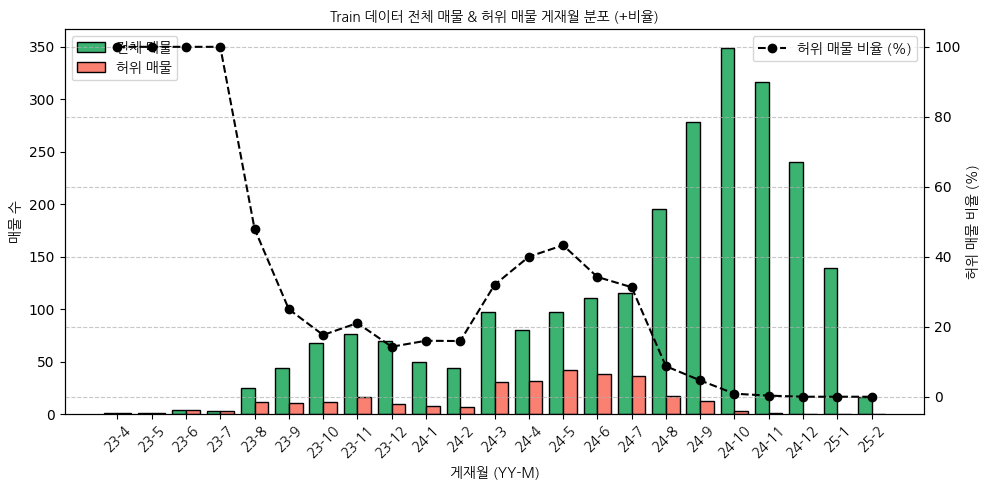

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 📌 현재 날짜 기준 미래 데이터 제거
today = pd.Timestamp.today()

# "게재일" 컬럼을 datetime 형식으로 변환
train["게재일"] = pd.to_datetime(train["게재일"], errors="coerce")

# 미래 데이터 제거 (오늘 날짜 이후 데이터 삭제)
train = train[train["게재일"] <= today]

# "게재월" 컬럼 생성 (YY-M 형식, 예: "24-1")
train["게재월"] = train["게재일"].dt.strftime("%y-%-m")

# 📊 전체 매물 & 허위 매물 개수 집계
total_M_counts = train["게재월"].value_counts()
fake_M_counts = train[train["허위매물여부"] == 1]["게재월"].value_counts()

# 📌 NaN 값 처리 및 정렬
sorted_index = sorted(total_M_counts.index, key=lambda x: [int(i) for i in x.split('-')])
total_M_counts_sorted = total_M_counts.reindex(sorted_index).fillna(0)
fake_M_counts_sorted = fake_M_counts.reindex(sorted_index).fillna(0)

# 📌 허위 매물 비율(%) 계산
fake_rates_sorted = (fake_M_counts_sorted / total_M_counts_sorted * 100).fillna(0)

# 📊 시각화 (전체 매물 vs 허위 매물 + 비율 추가)
fig, ax1 = plt.subplots(figsize=(10, 5))

bar_width = 0.4  # 막대 너비 설정
x_labels = total_M_counts_sorted.index  # x축 레이블
x_pos = np.arange(len(x_labels))  # x축 위치 설정

# 막대 그래프 (전체 매물 vs 허위 매물)
ax1.bar(x_pos, total_M_counts_sorted.values, width=bar_width, label="전체 매물", color="mediumseagreen", edgecolor="k")
ax1.bar([p + bar_width for p in x_pos], fake_M_counts_sorted.values, width=bar_width, label="허위 매물", color="salmon", edgecolor="k")

# 📌 2축 추가 (허위 매물 비율 %)
ax2 = ax1.twinx()
ax2.plot(x_pos + bar_width / 2, fake_rates_sorted.values, color="black", marker="o", linestyle="dashed", label="허위 매물 비율 (%)")

# 📌 그래프 설정 (폰트 오류 방지)
try:
    ax1.set_xticks(x_pos + bar_width / 2)
    ax1.set_xticklabels(x_labels, rotation=45, fontproperties=fontprop)
    ax1.set_xlabel("게재월 (YY-M)", fontsize=10, fontproperties=fontprop)
    ax1.set_ylabel("매물 수", fontsize=10, fontproperties=fontprop)
    ax2.set_ylabel("허위 매물 비율 (%)", fontsize=10, color="black", fontproperties=fontprop)
    plt.title("Train 데이터 전체 매물 & 허위 매물 게재월 분포 (+비율)", fontsize=12, fontproperties=fontprop)
    ax1.legend(prop=fontprop, loc="upper left")
    ax2.legend(prop=fontprop, loc="upper right")
except NameError:
    ax1.set_xticks(x_pos + bar_width / 2)
    ax1.set_xticklabels(x_labels, rotation=45)
    ax1.set_xlabel("게재월 (YY-M)", fontsize=10)
    ax1.set_ylabel("매물 수", fontsize=10)
    ax2.set_ylabel("허위 매물 비율 (%)", fontsize=10, color="black")
    plt.title("Train 데이터 전체 매물 & 허위 매물 게재월 분포 (+ 허위 매물 비율)", fontsize=12)
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")

plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [17]:
train[train['게재월'] == '25-3']

,ID,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,게재일,허위매물여부,게재월


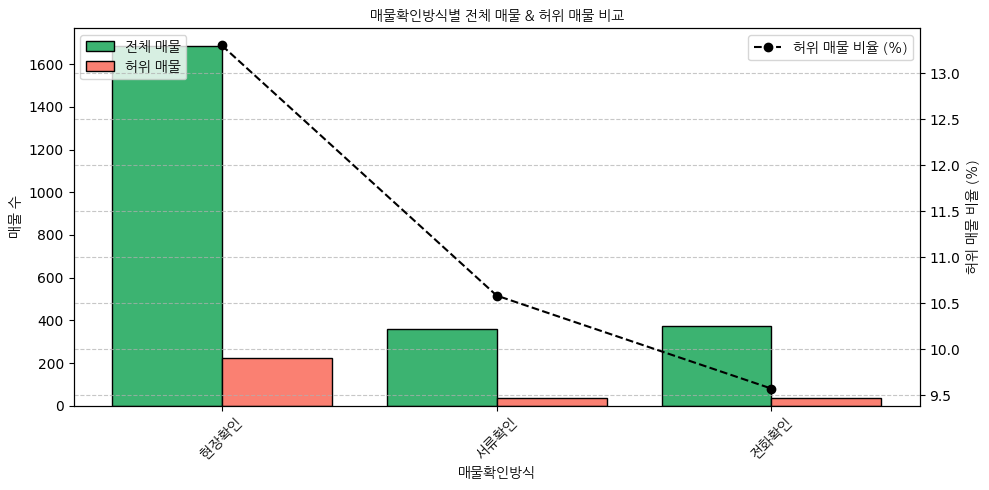

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 📊 매물확인방식별 전체 매물 개수 집계
total_check_counts = train["매물확인방식"].value_counts()

# 📊 매물확인방식별 허위 매물 개수 집계
fake_check_counts = train[train["허위매물여부"] == 1]["매물확인방식"].value_counts()

# 📌 허위 매물 비율 (%) 계산
check_methods = total_check_counts.index  # 모든 확인방식
fake_rates = (fake_check_counts / total_check_counts * 100).fillna(0)  # NaN -> 0 처리

# 📌 정렬 (허위 매물 비율 순 정렬)
sorted_index = fake_rates.sort_values(ascending=False).index
total_check_counts_sorted = total_check_counts.reindex(sorted_index)
fake_check_counts_sorted = fake_check_counts.reindex(sorted_index).fillna(0)
fake_rates_sorted = fake_rates.reindex(sorted_index)

# 📊 시각화 (매물확인방식별 전체 매물 vs 허위 매물)
fig, ax1 = plt.subplots(figsize=(10, 5))

bar_width = 0.4  # 막대 너비 설정
x_pos = np.arange(len(sorted_index))  # x축 위치 설정

ax1.bar(x_pos, total_check_counts_sorted.values, width=bar_width, label="전체 매물", color="mediumseagreen", edgecolor="k")
ax1.bar(x_pos + bar_width, fake_check_counts_sorted.values, width=bar_width, label="허위 매물", color="salmon", edgecolor="k")

# 📌 2축 추가 (허위 매물 비율 %)
ax2 = ax1.twinx()
ax2.plot(x_pos + bar_width / 2, fake_rates_sorted.values, color="black", marker="o", linestyle="dashed", label="허위 매물 비율 (%)")

# 📌 그래프 설정 (폰트 오류 방지)
try:
    ax1.set_xticks(x_pos + bar_width / 2)
    ax1.set_xticklabels(sorted_index, rotation=45, fontproperties=fontprop)
    ax1.set_xlabel("매물확인방식", fontsize=10, fontproperties=fontprop)
    ax1.set_ylabel("매물 수", fontsize=10, fontproperties=fontprop)
    ax2.set_ylabel("허위 매물 비율 (%)", fontsize=10, color="black", fontproperties=fontprop)
    plt.title("매물확인방식별 전체 매물 & 허위 매물 비교", fontsize=12, fontproperties=fontprop)
    ax1.legend(prop=fontprop, loc="upper left")
    ax2.legend(prop=fontprop, loc="upper right")
except NameError:
    ax1.set_xticks(x_pos + bar_width / 2)
    ax1.set_xticklabels(sorted_index, rotation=45)
    ax1.set_xlabel("매물확인방식", fontsize=10)
    ax1.set_ylabel("매물 수", fontsize=10)
    ax2.set_ylabel("허위 매물 비율 (%)", fontsize=10, color="black")
    plt.title("매물확인방식별 전체 매물 & 허위 매물 비교", fontsize=12)
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")

plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


범주형 변수 시각화:


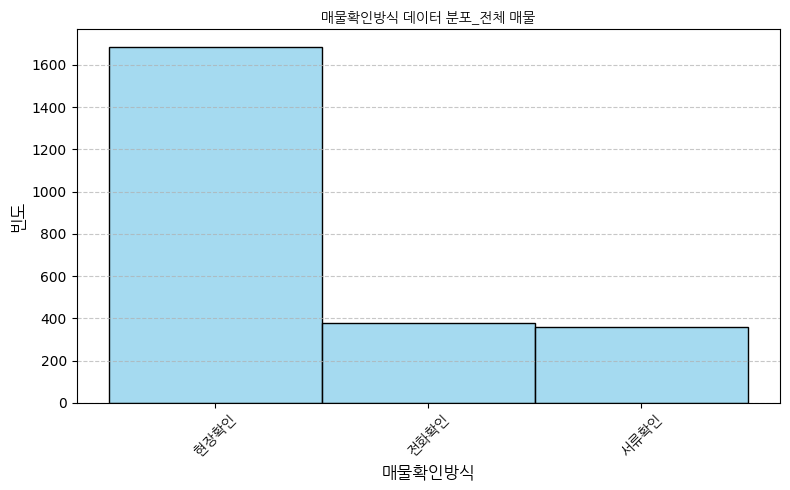

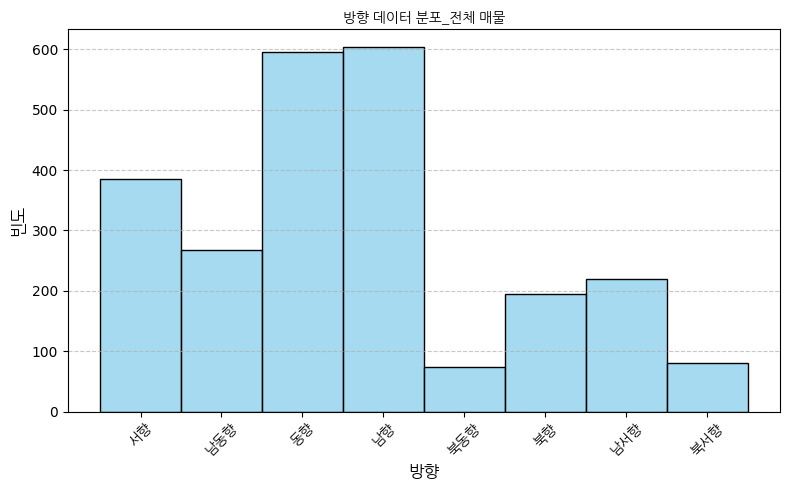

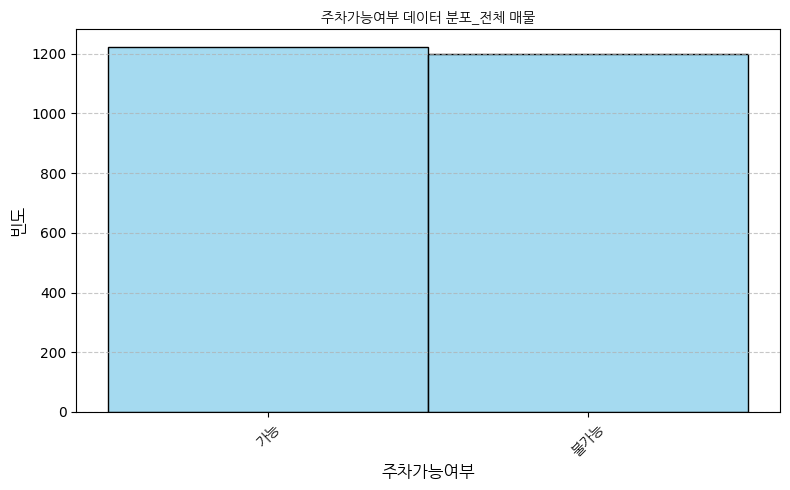

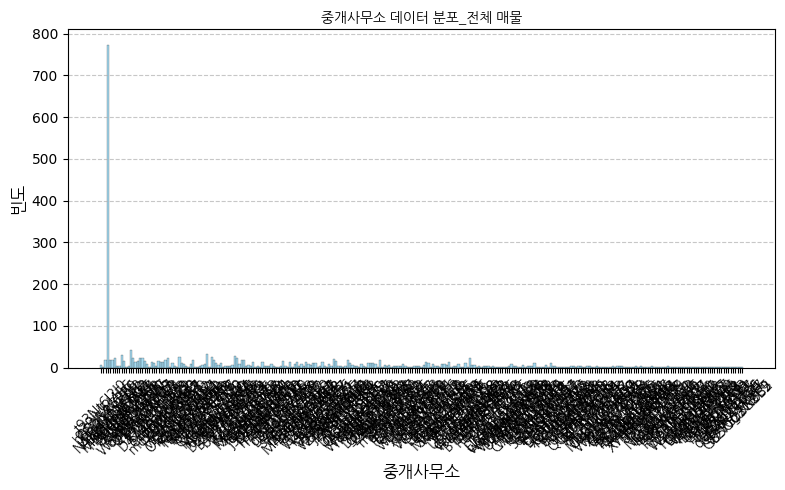

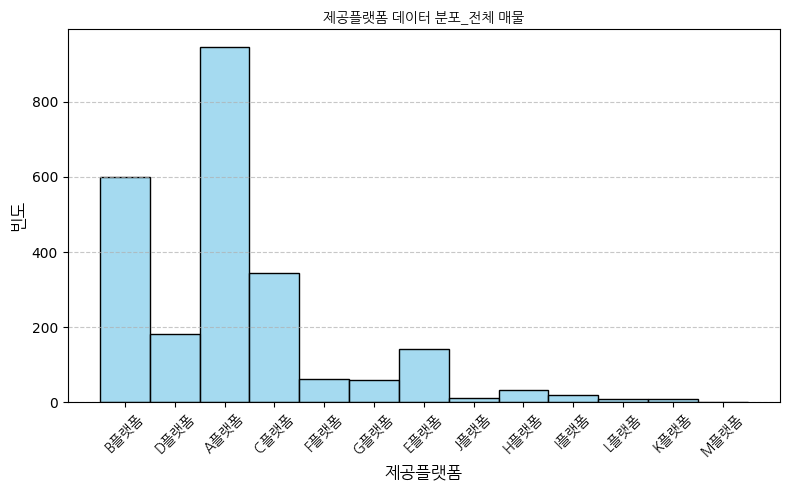

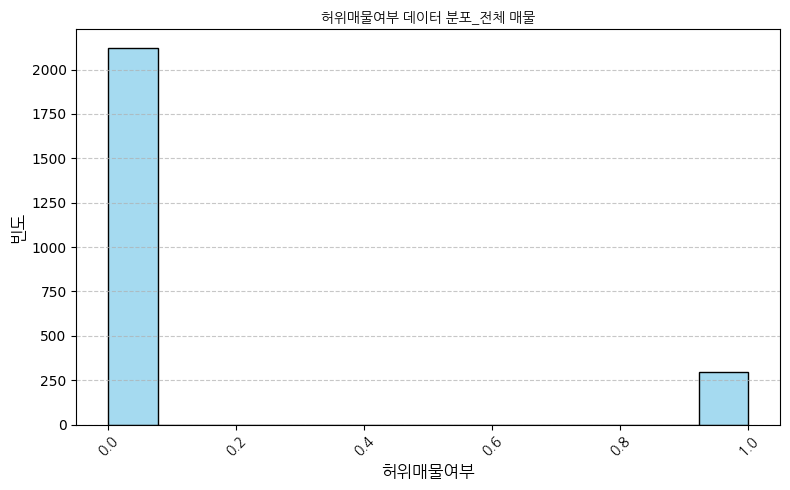

In [19]:
print("\n범주형 변수 시각화:")
for col in cate_columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(data=train, x=col, kde=False, color="skyblue", edgecolor="black")
    plt.title(f"{col} 데이터 분포_전체 매물", fontsize=14, fontproperties=fontprop)
    plt.xlabel(col, fontsize=12, fontproperties=fontprop)
    plt.ylabel("빈도", fontsize=12, fontproperties=fontprop)
    plt.xticks(rotation=45, fontsize=10, fontproperties=fontprop) # X축 라벨 회전 (범주형 데이터에 따라 필요)
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Y축 점선 그리드 추가
    plt.tight_layout()
    plt.show()

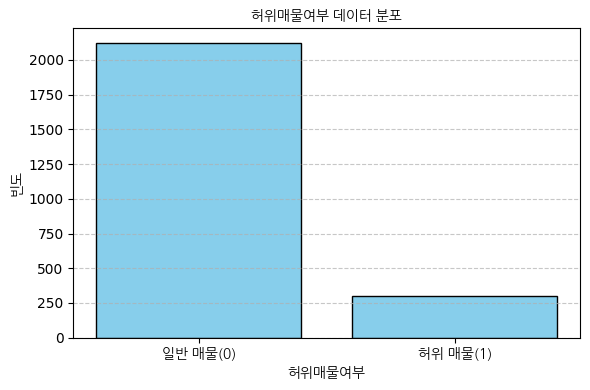

In [20]:
import matplotlib.pyplot as plt

# 📊 허위매물여부 데이터 분포 (0과 1 개수 집계)
fake_counts = train["허위매물여부"].value_counts()

# 📊 시각화 (0과 1만 표시)
plt.figure(figsize=(6, 4))
plt.bar(fake_counts.index, fake_counts.values, color="skyblue", edgecolor="k")

# 📌 X축을 0과 1만 표시
plt.xticks([0, 1], labels=["일반 매물(0)", "허위 매물(1)"], fontproperties=fontprop)
plt.xlabel("허위매물여부", fontsize=10, fontproperties=fontprop)
plt.ylabel("빈도", fontsize=10, fontproperties=fontprop)
plt.title("허위매물여부 데이터 분포", fontsize=12, fontproperties=fontprop)

plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

###### 범주형 변수 자세히 시각화

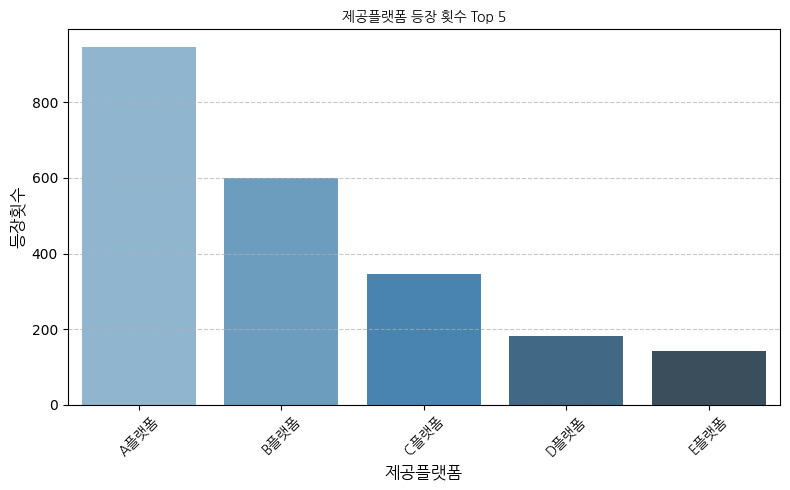

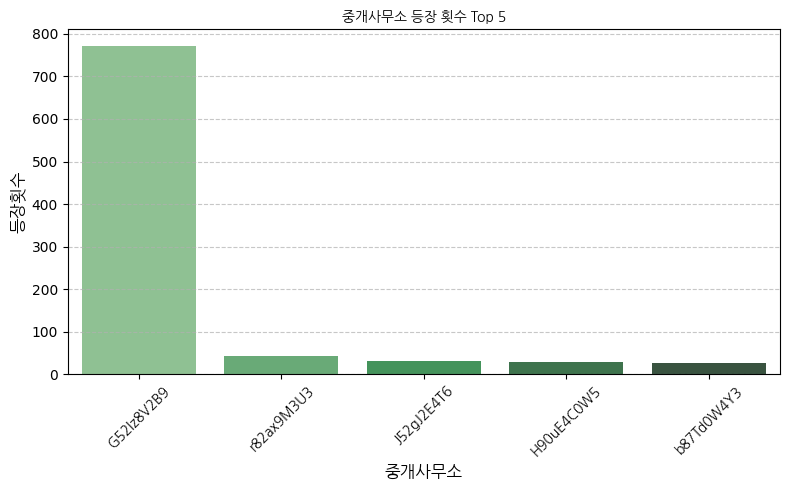

In [21]:
platform_counts = train['제공플랫폼'].value_counts()
office_counts = train['중개사무소'].value_counts()

top5_data = {
    "제공플랫폼": platform_counts.nlargest(5),  # 열 이름 제거
    "중개사무소": office_counts.nlargest(5)    # 열 이름 제거
}

palette = {"제공플랫폼": "Blues_d", "중개사무소": "Greens_d"}

for col, data in top5_data.items():
    plt.figure(figsize=(8, 5))
    sns.barplot(x=data.index, y=data.values, palette=palette[col])
    plt.title(f"{col} 등장 횟수 Top 5", fontsize=14, fontproperties=fontprop)
    plt.xlabel(col, fontsize=12, fontproperties=fontprop)
    plt.ylabel("등장횟수", fontsize=12, fontproperties=fontprop)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45, fontproperties=fontprop)
    plt.tight_layout()
    plt.show()

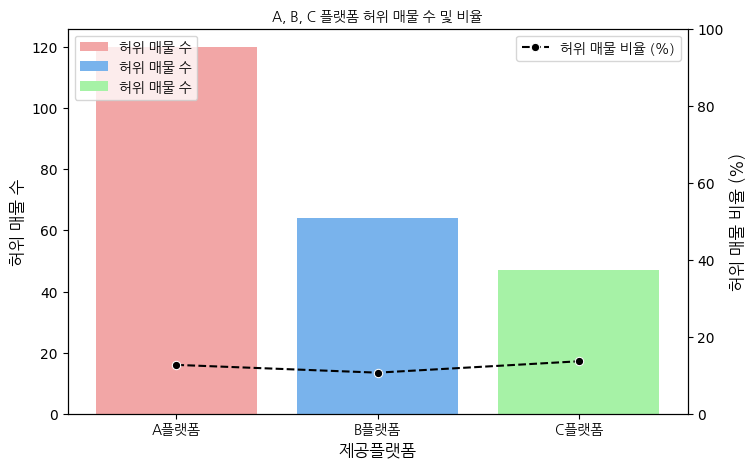

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# 📌 상위 3개 플랫폼 선택 (A, B, C 플랫폼만 필터링)
top_platforms = ["A플랫폼", "B플랫폼", "C플랫폼"]
train_top_platforms = train[train["제공플랫폼"].isin(top_platforms)]

# 📌 전체 매물 개수 & 허위 매물 개수 계산
platform_counts = train_top_platforms["제공플랫폼"].value_counts()
fake_counts = train_top_platforms[train_top_platforms["허위매물여부"] == 1]["제공플랫폼"].value_counts()

# 📌 허위 매물 비율 계산
fake_ratio = (fake_counts / platform_counts * 100).fillna(0)  # NaN 방지

# 📊 시각화: 허위 매물 개수 및 비율
fig, ax1 = plt.subplots(figsize=(8, 5))

# 🎨 플랫폼별 개별 색상 지정
platform_colors = ["#FF9999", "#66B3FF", "#99FF99"]  # A: 연한빨강, B: 연한파랑, C: 연한초록

# 🔹 허위 매물 개수 (막대 그래프)
sns.barplot(x=fake_counts.index, y=fake_counts.values, palette=platform_colors, label="허위 매물 수", ax=ax1)
ax1.set_ylabel("허위 매물 수", fontsize=12, fontproperties=fontprop)
ax1.set_xlabel("제공플랫폼", fontsize=12, fontproperties=fontprop)
ax1.set_title("A, B, C 플랫폼 허위 매물 수 및 비율", fontsize=14, fontproperties=fontprop)
ax1.tick_params(axis="y")

# 📌 🔥 x축 라벨(제공플랫폼) 폰트 적용
ax1.set_xticklabels(fake_counts.index, fontproperties=fontprop, fontsize=10)

# 🔹 허위 매물 비율 (선 그래프)
ax2 = ax1.twinx()
sns.lineplot(x=fake_ratio.index, y=fake_ratio.values, color="black", marker="o", linestyle="dashed", label="허위 매물 비율 (%)", ax=ax2)
ax2.set_ylabel("허위 매물 비율 (%)", fontsize=12, fontproperties=fontprop)
ax2.set_ylim(0, 100)  # 비율 범위 설정

# 📌 범례 설정
ax1.legend(loc="upper left", fontsize=10, prop=fontprop)
ax2.legend(loc="upper right", fontsize=10, prop=fontprop)

plt.show()

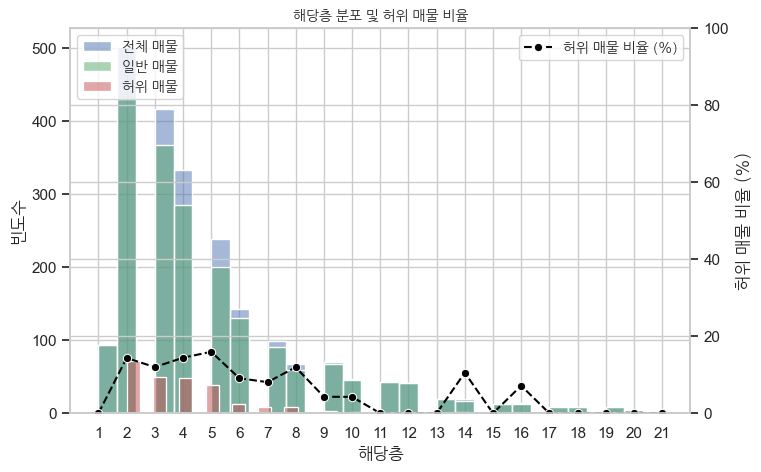

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# 📌 Seaborn 스타일 설정
sns.set_theme(style="whitegrid")

# 📌 색상 설정 (각 그룹별 개별 색상)
colors = {"전체 매물": "#4C72B0", "일반 매물": "#55A868", "허위 매물": "#C44E52"}

# 📌 전체 매물, 일반 매물(허위매물여부=0), 허위 매물(허위매물여부=1) 데이터 분리
train_total = train["해당층"]
train_real = train[train["허위매물여부"] == 0]["해당층"]
train_fake = train[train["허위매물여부"] == 1]["해당층"]

# 📊 허위 매물 비율 계산
floor_counts = train["해당층"].value_counts().sort_index()  # 각 층별 전체 매물 개수
fake_counts = train[train["허위매물여부"] == 1]["해당층"].value_counts().sort_index()  # 각 층별 허위 매물 개수
fake_ratio = (fake_counts / floor_counts * 100).fillna(0)  # 허위 매물 비율 계산 (%)

# 📊 해당층 분포 히스토그램 & 허위 매물 비율
fig, ax1 = plt.subplots(figsize=(8, 5))

# 🔹 해당층 히스토그램 (전체 매물, 일반 매물, 허위 매물)
sns.histplot(train_total, bins=30, color=colors["전체 매물"], label="전체 매물", alpha=0.5, ax=ax1)
sns.histplot(train_real, bins=30, color=colors["일반 매물"], label="일반 매물", alpha=0.5, ax=ax1)
sns.histplot(train_fake, bins=30, color=colors["허위 매물"], label="허위 매물", alpha=0.5, ax=ax1)

# 📌 X축 1 단위로 설정
min_floor = int(train["해당층"].min())  # 최소값 (정수 변환)
max_floor = int(train["해당층"].max())  # 최대값 (정수 변환)
ax1.set_xticks(range(min_floor, max_floor + 1, 1))  # 1씩 증가
ax1.set_xlabel("해당층", fontsize=12, fontproperties=fontprop)
ax1.set_ylabel("빈도수", fontsize=12, fontproperties=fontprop)

# 🔹 허위 매물 비율 선 그래프 추가 (이중 축)
ax2 = ax1.twinx()
sns.lineplot(x=fake_ratio.index, y=fake_ratio.values, color="black", marker="o", linestyle="dashed", label="허위 매물 비율 (%)", ax=ax2)
ax2.set_ylabel("허위 매물 비율 (%)", fontsize=12, fontproperties=fontprop)
ax2.set_ylim(0, 100)  # 비율 범위 0~100%

# 📌 제목 및 범례 설정
plt.title("해당층 분포 및 허위 매물 비율", fontsize=14, fontproperties=fontprop)
ax1.legend(prop=fontprop, fontsize=10, loc="upper left")
ax2.legend(prop=fontprop, fontsize=10, loc="upper right")

plt.show()

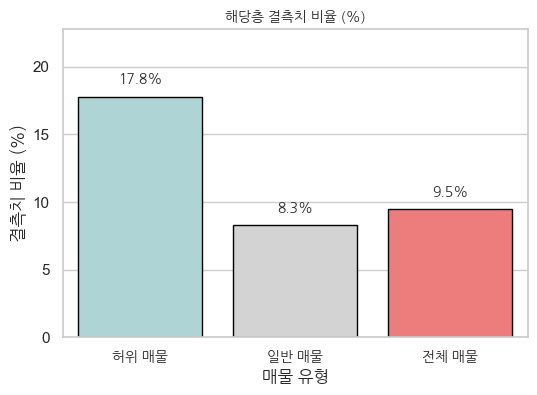

In [36]:
# 📌 Seaborn 스타일 설정
sns.set_theme(style="whitegrid")

# 📌 허위 매물, 일반 매물, 전체 매물 데이터셋 분리
false_listing = train[train["허위매물여부"] == 1]  # 허위 매물
real_listing = train[train["허위매물여부"] == 0]  # 일반 매물

# 📌 해당층 결측치 비율 계산
false_missing_ratio = (false_listing["해당층"].isnull().sum() / len(false_listing)) * 100
real_missing_ratio = (real_listing["해당층"].isnull().sum() / len(real_listing)) * 100
total_missing_ratio = (train["해당층"].isnull().sum() / len(train)) * 100

# 📌 데이터프레임 생성
missing_data = pd.DataFrame({
    "매물 유형": ["허위 매물", "일반 매물", "전체 매물"],
    "결측치 비율 (%)": [false_missing_ratio, real_missing_ratio, total_missing_ratio]
})

# 📊 색상 설정
colors = ["#A8DADC", "#D3D3D3", "#FF6B6B"]  # 허위 매물(파랑), 일반 매물(회색), 전체(빨강)

# 📊 시각화: 허위 매물, 일반 매물, 전체 매물의 해당층 결측 비율
plt.figure(figsize=(6, 4))
sns.barplot(x="매물 유형", y="결측치 비율 (%)", data=missing_data, palette=colors, edgecolor="black")

# 📌 제목 및 라벨 설정
plt.title("해당층 결측치 비율 (%)", fontsize=14, fontproperties=fontprop)
plt.xlabel("매물 유형", fontsize=12, fontproperties=fontprop)
plt.ylabel("결측치 비율 (%)", fontsize=12, fontproperties=fontprop)

# 📌 X축 폰트 적용
plt.xticks(fontproperties=fontprop, fontsize=10)  # 🔥 X축 폰트 적용

# 📌 Y축 범위 설정 (0~최대값 + 여유공간)
plt.ylim(0, max(missing_data["결측치 비율 (%)"]) + 5)

# 📌 막대 위에 비율 값 표시
for i, value in enumerate(missing_data["결측치 비율 (%)"]):
    plt.text(i, value + 1, f"{value:.1f}%", ha="center", fontsize=10, fontproperties=fontprop)

plt.show()

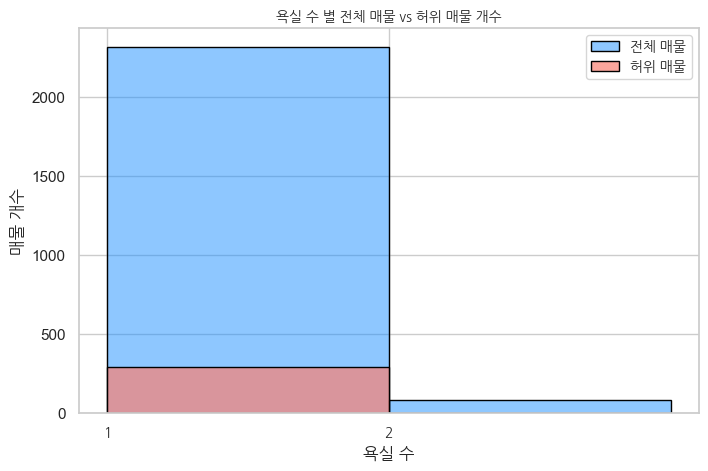

In [ ]:
# 📌 Seaborn 스타일 설정
sns.set_theme(style="whitegrid")

# 📌 데이터 분리
bathroom_total = train["욕실수"]  # 전체 매물
bathroom_fake = train[train["허위매물여부"] == 1]["욕실수"]  # 허위 매물만 선택

# 📊 욕실 수 별 전체 매물 & 허위 매물 비교 히스토그램
plt.figure(figsize=(8, 5))
sns.histplot(bathroom_total, bins=range(int(bathroom_total.min()), int(bathroom_total.max()) + 2),
             color="dodgerblue", edgecolor="black", alpha=0.5, label="전체 매물")
sns.histplot(bathroom_fake, bins=range(int(bathroom_fake.min()), int(bathroom_fake.max()) + 2),
             color="salmon", edgecolor="black", alpha=0.7, label="허위 매물")

# 📌 X축 1 단위로 설정
plt.xticks(range(int(bathroom_total.min()), int(bathroom_total.max()) + 1, 1), 
           fontproperties=fontprop, fontsize=10)

# 📌 제목 및 축 라벨 설정
plt.title("욕실 수 별 전체 매물 vs 허위 매물 개수", fontsize=14, fontproperties=fontprop)
plt.xlabel("욕실 수", fontsize=12, fontproperties=fontprop)
plt.ylabel("매물 개수", fontsize=12, fontproperties=fontprop)

# 📌 범례 추가 (폰트 적용)
plt.legend(prop=fontprop, fontsize=10)

plt.show()

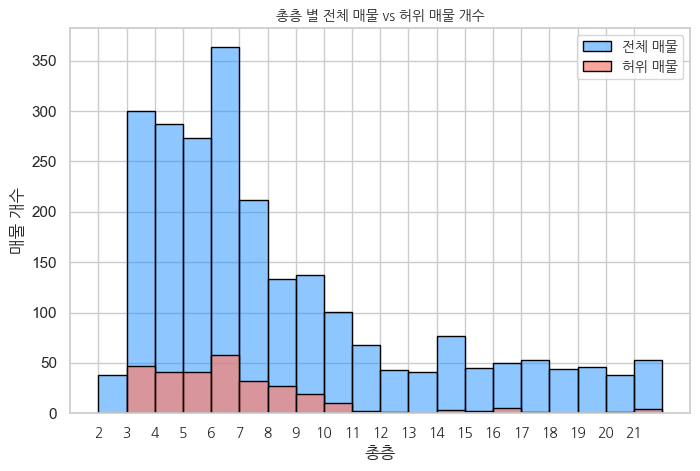

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# 📌 Seaborn 스타일 설정
sns.set_theme(style="whitegrid")

# 📌 색상 설정
colors = {"전체 매물": "dodgerblue", "허위 매물": "salmon"}

# 📌 총층 데이터 분리
floor_total = train["총층"]
floor_fake = train[train["허위매물여부"] == 1]["총층"]

# 📊 총층 히스토그램 (전체 매물 vs 허위 매물)
plt.figure(figsize=(8, 5))
sns.histplot(floor_total, bins=range(int(floor_total.min()), int(floor_total.max()) + 2),
             color=colors["전체 매물"], edgecolor="black", alpha=0.5, label="전체 매물")
sns.histplot(floor_fake, bins=range(int(floor_fake.min()), int(floor_fake.max()) + 2),
             color=colors["허위 매물"], edgecolor="black", alpha=0.7, label="허위 매물")

# 📌 X축 1 단위로 설정
plt.xticks(range(int(floor_total.min()), int(floor_total.max()) + 1, 1), 
           fontproperties=fontprop, fontsize=10)

# 📌 제목 및 축 라벨 설정
plt.title("총층 별 전체 매물 vs 허위 매물 개수", fontsize=14, fontproperties=fontprop)
plt.xlabel("총층", fontsize=12, fontproperties=fontprop)
plt.ylabel("매물 개수", fontsize=12, fontproperties=fontprop)
plt.legend(prop=fontprop, fontsize=10)

plt.show()

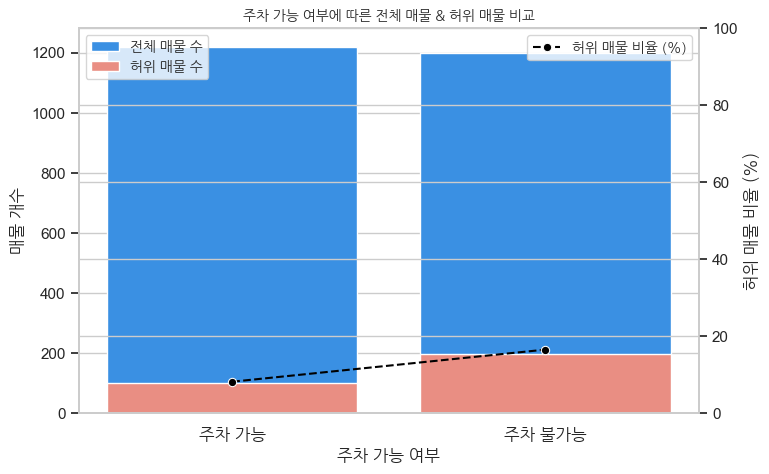

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# 📌 Seaborn 스타일 설정
sns.set_theme(style="whitegrid")

# 📌 주차 가능 여부 데이터 분리
parking_total = train["주차가능여부"].value_counts()
parking_fake = train[train["허위매물여부"] == 1]["주차가능여부"].value_counts()

# 📌 허위 매물 비율 계산
parking_ratio = (parking_fake / parking_total * 100).fillna(0)

# 📊 시각화: 전체 매물 & 허위 매물 비교
fig, ax1 = plt.subplots(figsize=(8, 5))

# 🔹 전체 매물 개수 (막대 그래프)
sns.barplot(x=parking_total.index, y=parking_total.values, color="dodgerblue", label="전체 매물 수", ax=ax1)
sns.barplot(x=parking_fake.index, y=parking_fake.values, color="salmon", label="허위 매물 수", ax=ax1)

# 📌 X축 폰트 적용 (주차 가능/불가능)
ax1.set_xticklabels(ax1.get_xticklabels(), fontproperties=fontprop, fontsize=12)

# 📌 축 라벨 및 제목 설정
ax1.set_ylabel("매물 개수", fontsize=12, fontproperties=fontprop)
ax1.set_xlabel("주차 가능 여부", fontsize=12, fontproperties=fontprop)
ax1.set_title("주차 가능 여부에 따른 전체 매물 & 허위 매물 비교", fontsize=14, fontproperties=fontprop)

# 🔹 허위 매물 비율 (선 그래프)
ax2 = ax1.twinx()
sns.lineplot(x=parking_ratio.index, y=parking_ratio.values, color="black", marker="o", linestyle="dashed", label="허위 매물 비율 (%)", ax=ax2)

# 📌 허위 매물 비율 Y축 설정
ax2.set_ylabel("허위 매물 비율 (%)", fontsize=12, fontproperties=fontprop)
ax2.set_ylim(0, 100)  # 비율 범위 설정

# 📌 X축 변수 폰트 적용 (주차 가능 / 불가능)
ax1.set_xticklabels(["주차 가능", "주차 불가능"], fontproperties=fontprop, fontsize=12)

# 📌 범례 설정
ax1.legend(loc="upper left", fontsize=10, prop = fontprop)
ax2.legend(loc="upper right", fontsize=10, prop = fontprop)

plt.show()

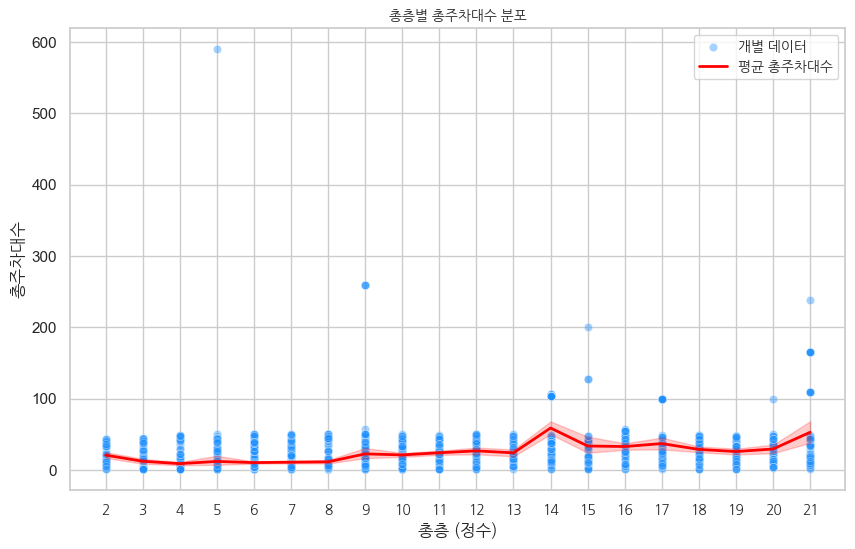

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# 📌 결측치 제거
filtered_data = train.dropna(subset=["총층", "총주차대수"]).copy()

# 📌 총층을 정수형으로 변환 (혹시 float일 경우 대비)
filtered_data["총층"] = filtered_data["총층"].astype(int)

# 📊 시각화: 총층별 총주차대수 산점도 + 평균 추세선
plt.figure(figsize=(10, 6))
sns.scatterplot(x=filtered_data["총층"], y=filtered_data["총주차대수"], alpha=0.4, color="dodgerblue", label="개별 데이터")
sns.lineplot(x=filtered_data["총층"], y=filtered_data["총주차대수"], estimator="mean", color="red", label="평균 총주차대수", linewidth=2)

# 📌 X축을 정수형으로 설정 (1 단위)
plt.xticks(sorted(filtered_data["총층"].unique()), fontproperties=fontprop, fontsize=10)

# 📌 제목 및 축 라벨 (폰트 적용)
plt.title("총층별 총주차대수 분포", fontsize=14, fontproperties=fontprop)
plt.xlabel("총층 (정수)", fontsize=12, fontproperties=fontprop)
plt.ylabel("총주차대수", fontsize=12, fontproperties=fontprop)

# 📌 범례 추가
plt.legend(prop=fontprop, fontsize=10)

plt.show()

- 중개사무소 G52Iz8V2B9는 허위매물이 없는 중개사무소

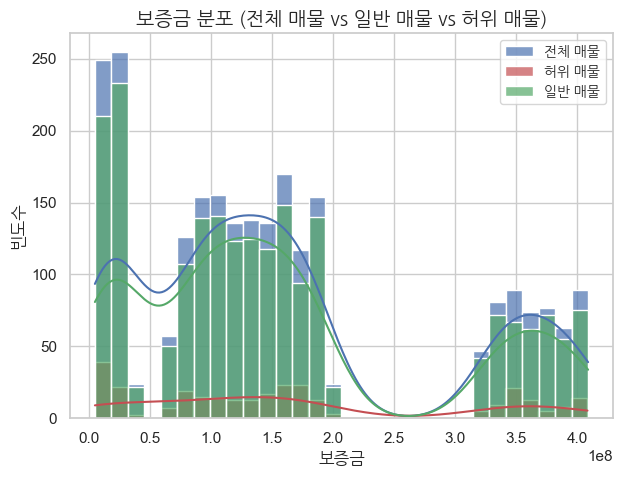

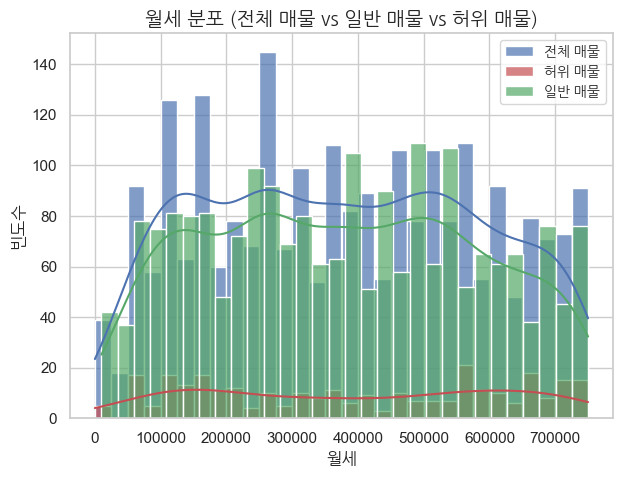

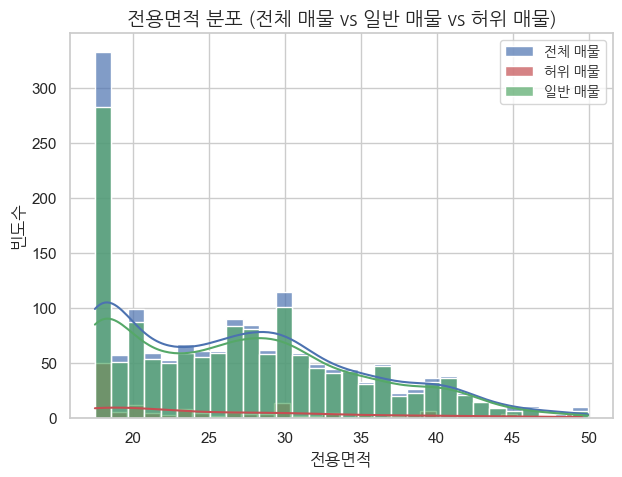

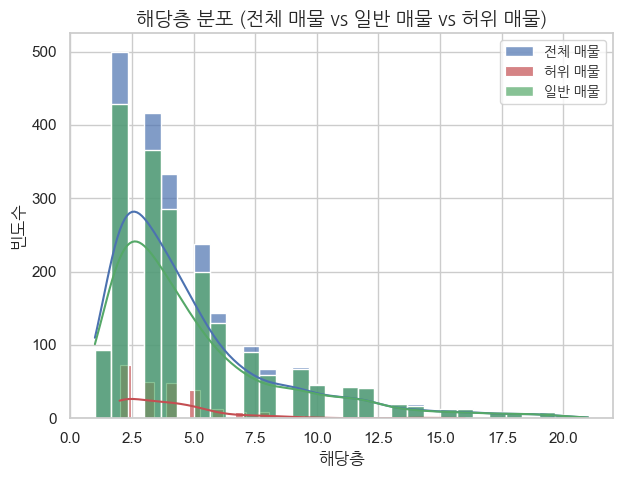

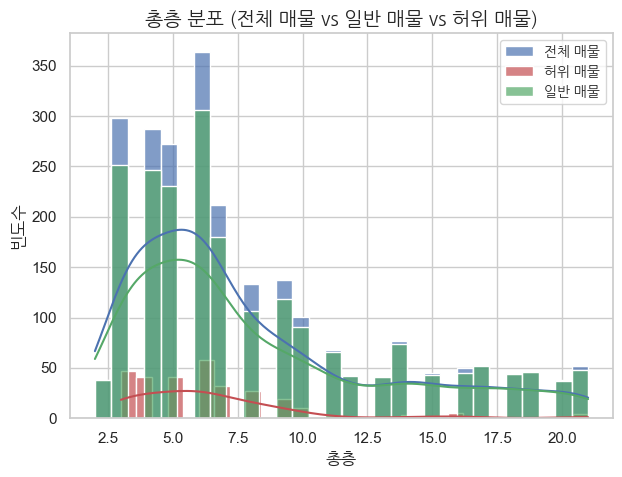

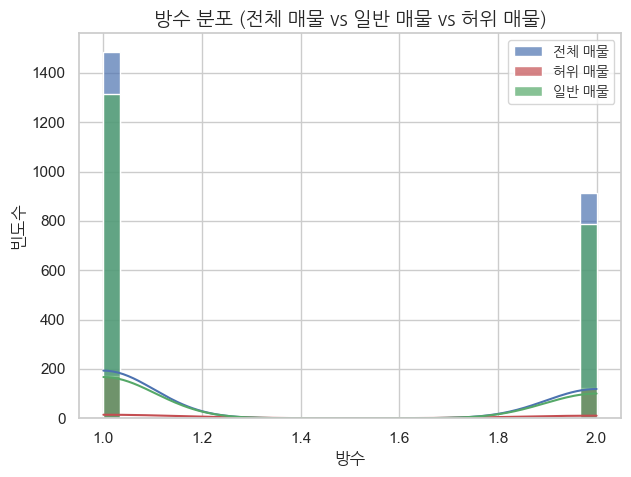

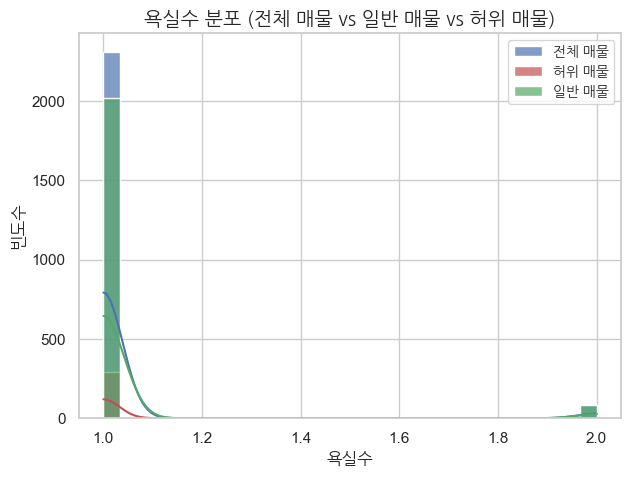

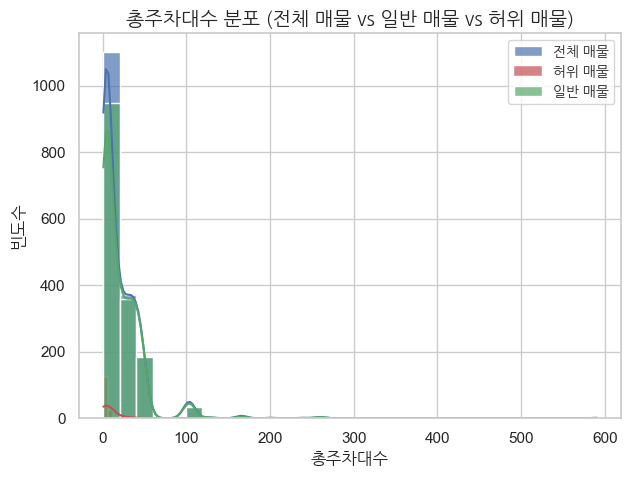

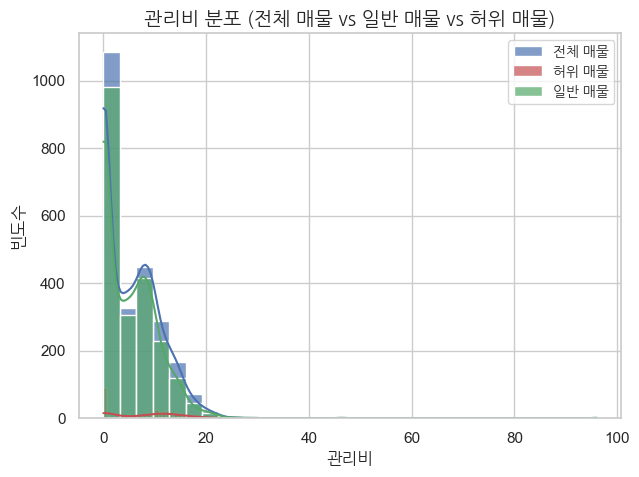

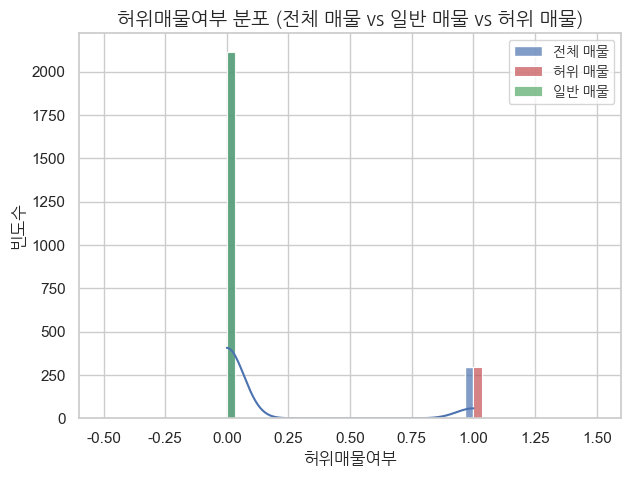

In [ ]:
# 📌 Seaborn 스타일 설정
sns.set_theme(style="whitegrid")

# 📌 수치형 변수 선택
numeric_columns = train.select_dtypes(include=["float64", "int64"]).columns

# 📌 색상 설정 (Seaborn deep color palette 활용 - 더 진한 색상)
colors = sns.color_palette("deep")  # 진한 색상 적용
color_total = colors[0]  # 전체 매물 색상 (진한 파랑)
color_fake = colors[3]   # 허위 매물 색상 (진한 주황)
color_real = colors[2]   # 일반 매물 색상 (진한 초록)

# 📌 전체 매물, 허위 매물, 일반 매물(허위매물여부=0) 분포 비교
for col in numeric_columns:
    plt.figure(figsize=(7, 5))
    
    # 🔥 전체 매물, 허위 매물, 일반 매물 분포를 함께 시각화
    sns.histplot(train[col], kde=True, bins=30, color=color_total, label="전체 매물", alpha=0.7)
    sns.histplot(train[train["허위매물여부"] == 1][col], kde=True, bins=30, color=color_fake, label="허위 매물", alpha=0.7)
    sns.histplot(train[train["허위매물여부"] == 0][col], kde=True, bins=30, color=color_real, label="일반 매물", alpha=0.7)
    
    # 📌 제목 및 축 레이블
    plt.title(f"{col} 분포 (전체 매물 vs 일반 매물 vs 허위 매물)", fontproperties=fontprop, fontsize=14)
    plt.xlabel(col, fontproperties=fontprop, fontsize=12)
    plt.ylabel("빈도수", fontproperties=fontprop, fontsize=12)

    # 📌 범례 (더 보기 좋게 조정)
    plt.legend(prop=fontprop, fontsize=10, loc="upper right", frameon=True, fancybox=True)

    plt.show()

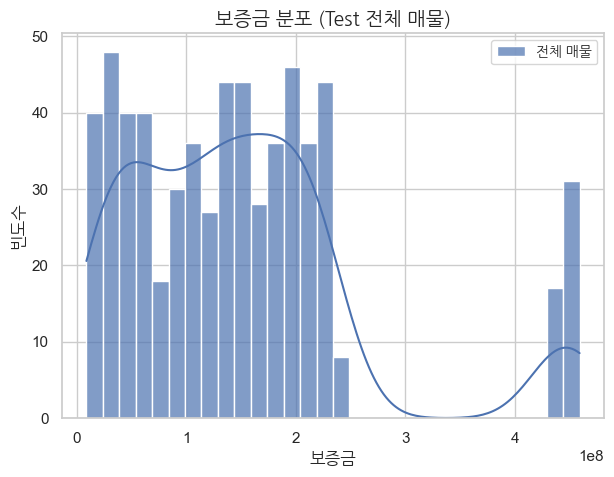

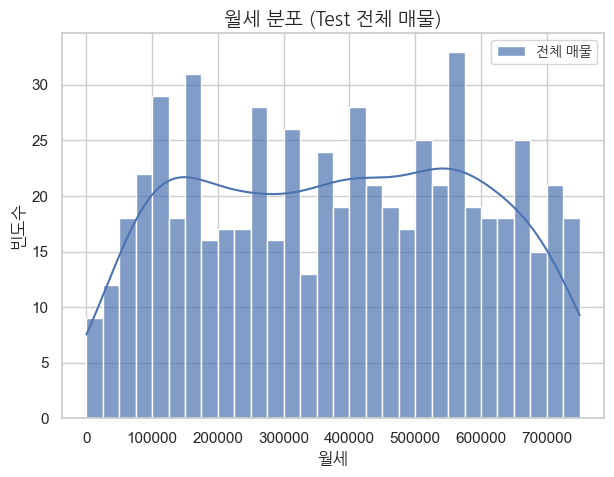

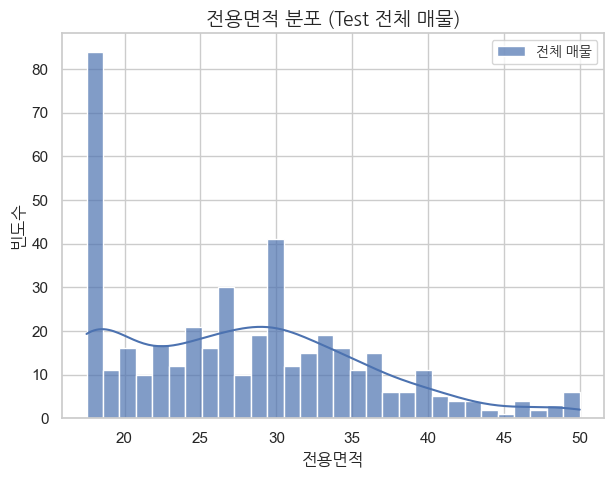

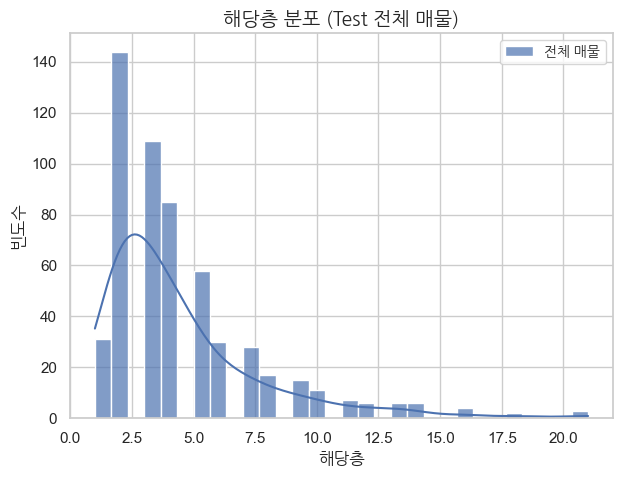

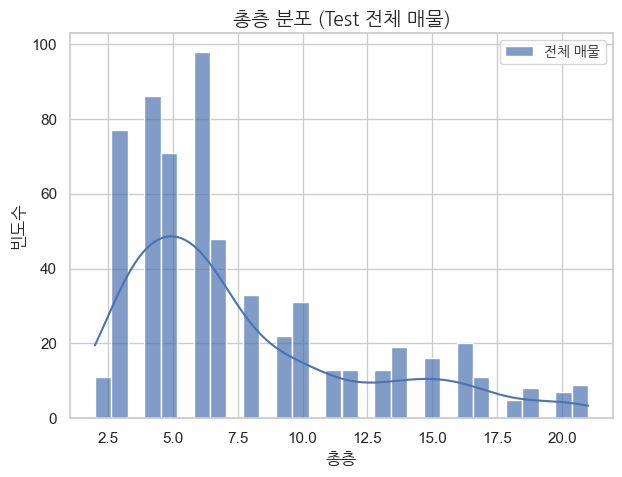

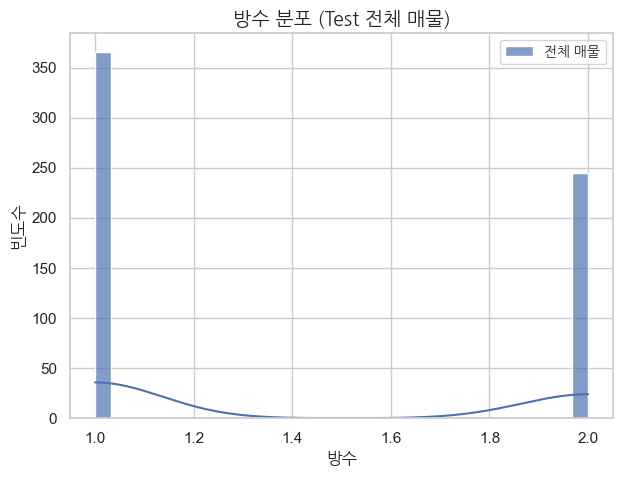

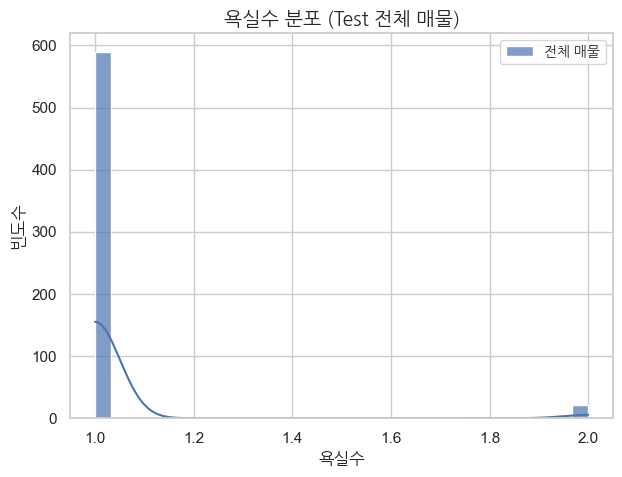

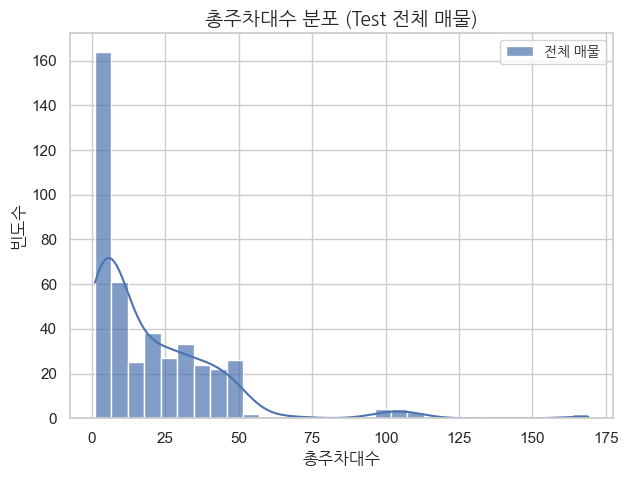

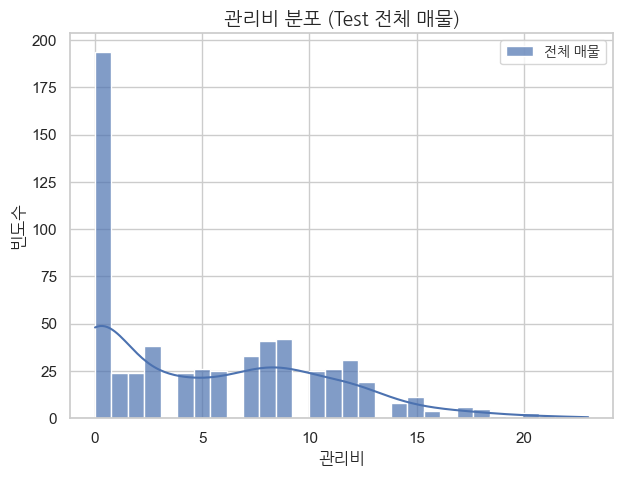

In [69]:
# 📌 Seaborn 스타일 설정
sns.set_theme(style="whitegrid")

# 📌 수치형 변수 선택
numeric_columns = test.select_dtypes(include=["float64", "int64"]).columns

# 📌 색상 설정 (Seaborn deep color palette 활용 - 더 진한 색상)
colors = sns.color_palette("deep")  # 진한 색상 적용
color_total = colors[0]  # 전체 매물 색상 (진한 파랑)

# 📌 전체 매물, 허위 매물, 일반 매물(허위매물여부=0) 분포 비교
for col in numeric_columns:
    plt.figure(figsize=(7, 5))
    
    # 🔥 전체 매물, 허위 매물, 일반 매물 분포를 함께 시각화
    sns.histplot(test[col], kde=True, bins=30, color=color_total, label="전체 매물", alpha=0.7)
    
    # 📌 제목 및 축 레이블
    plt.title(f"{col} 분포 (Test 전체 매물)", fontproperties=fontprop, fontsize=14)
    plt.xlabel(col, fontproperties=fontprop, fontsize=12)
    plt.ylabel("빈도수", fontproperties=fontprop, fontsize=12)

    # 📌 범례 (더 보기 좋게 조정)
    plt.legend(prop=fontprop, fontsize=10, loc="upper right", frameon=True, fancybox=True)

    plt.show()

In [19]:
# # 상관관계 분석 (수치형 데이터) -> 상관관계 거의 무쓸모
# plt.figure(figsize=(8, 6))
# sns.heatmap(train[numeric_columns].corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
# plt.title("상관관계 분석", fontsize=10, fontproperties=fontprop)
# plt.show()

#### 허위 매물 확인

In [20]:
fake_train = train[train['허위매물여부'] == 1]
print("fake_train 데이터 수 : ", len(fake_train))
print(fake_train.isna().sum())
# 널데이터 상황 : 298
#     전용면적 : 139
#     해당층 : 53
#     총층 : 4
#     방수 : 4
#     욕실수 : 4
#     총주차대수 : 122

fake_train 데이터 수 :  298
ID          0
매물확인방식      0
보증금         0
월세          0
전용면적      139
해당층        53
총층          4
방향          0
방수          4
욕실수         4
주차가능여부      0
총주차대수     122
관리비         0
중개사무소       0
제공플랫폼       0
게재일         0
허위매물여부      0
dtype: int64



범주형 변수 시각화:


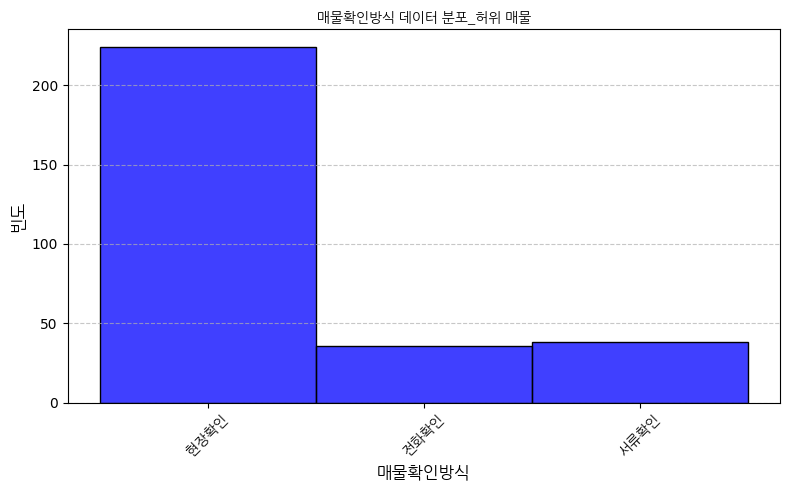

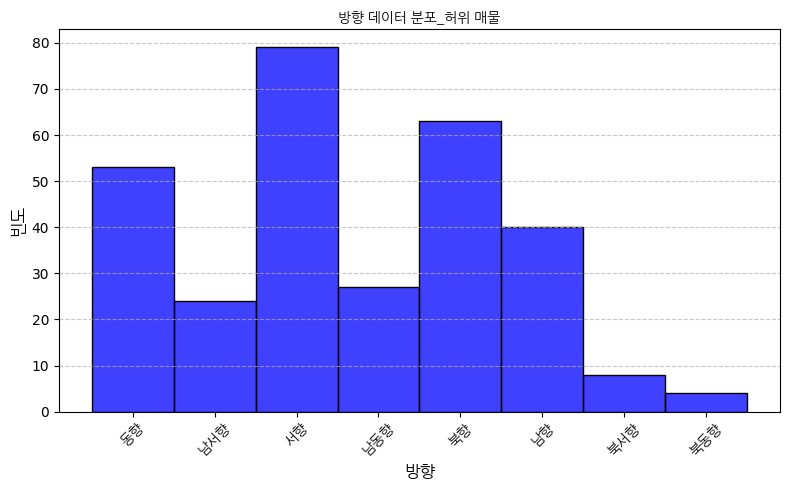

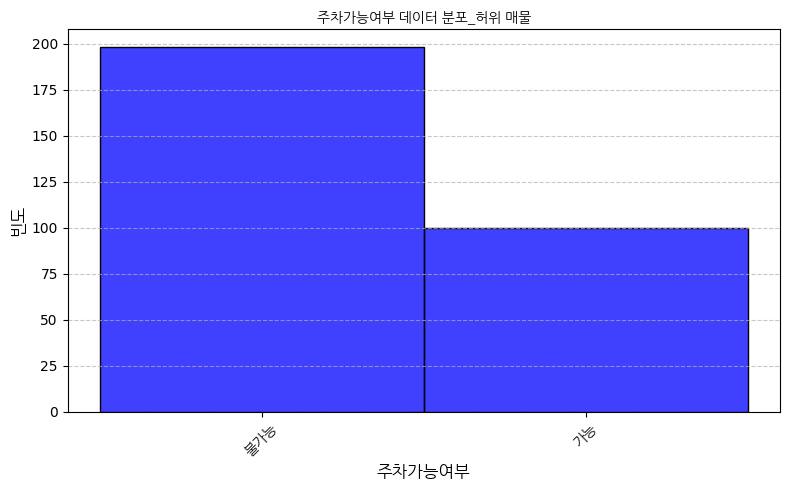

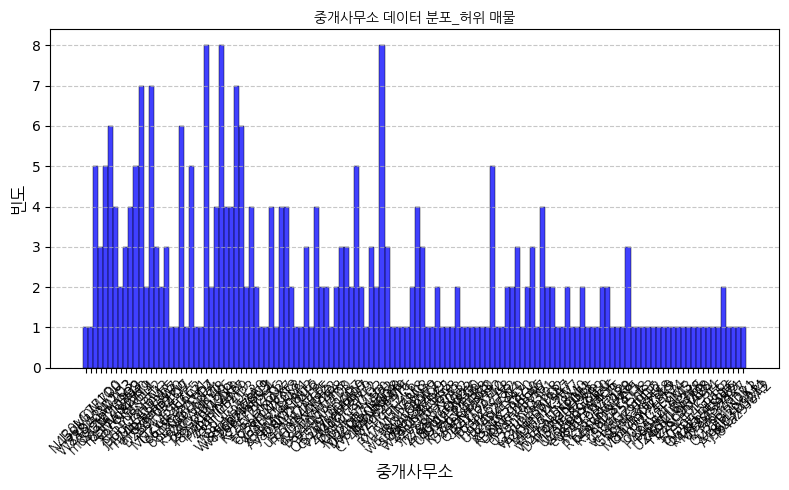

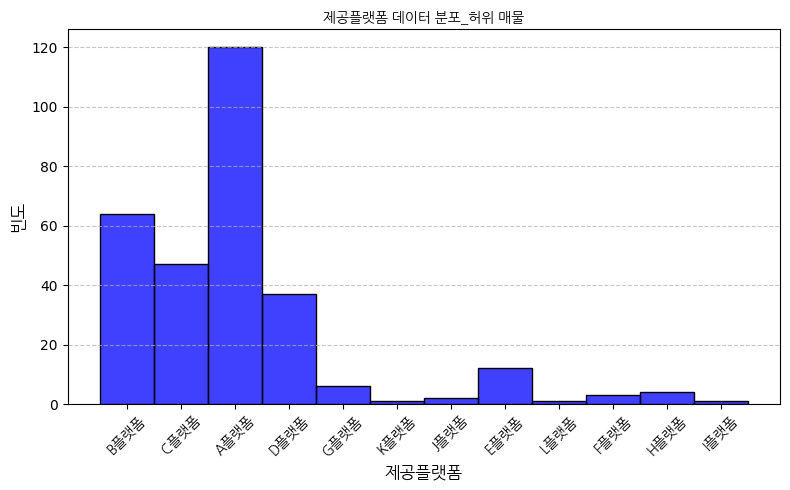

In [21]:
print("\n범주형 변수 시각화:")
for col in cate_columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(data=fake_train, x=col, kde=False, color="blue", edgecolor="black")
    plt.title(f"{col} 데이터 분포_허위 매물", fontsize=14, fontproperties=fontprop)
    plt.xlabel(col, fontsize=12, fontproperties=fontprop)
    plt.ylabel("빈도", fontsize=12, fontproperties=fontprop)
    plt.xticks(rotation=45, fontsize=10, fontproperties=fontprop) # X축 라벨 회전 (범주형 데이터에 따라 필요)
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Y축 점선 그리드 추가
    plt.tight_layout()
    plt.show()

In [22]:
frequent_offices = fake_train['중개사무소'].value_counts()
frequent_offices = frequent_offices[frequent_offices >= 3].index
fake_train[fake_train['중개사무소'].isin(frequent_offices)]['중개사무소'].value_counts()

중개사무소
J52gJ2E4T6    8
z54Fl0B2P9    8
r82ax9M3U3    8
w85cb3W8U9    7
H90uE4C0W5    7
a15xR3G4V0    7
r16Dr6Z7C3    6
o80Xg3Q1Q7    6
S12iP7V0Q9    6
U93ap2F8Z1    5
M02bn7Y4P0    5
k52HR5N1Z1    5
W88DA3W2Q3    5
j90UQ8N6M3    5
m69GM9O9B3    5
b87Td0W4Y3    4
K25cF2K7X6    4
w94Qb4G0K5    4
y86qM5T6T6    4
A72Mx9C8U2    4
Y65Hw0Z3K0    4
x68FU7B0S3    4
L43HH2L9R7    4
X95Bu4S5H2    4
W88hM2E2A9    4
K86UF7I0P3    4
r74nn1Y4T7    4
w37Qk3B9D2    3
J07Zn4B0R7    3
Z81Jv8Z5G2    3
X71Iq5L2C6    3
M92wE9E7E5    3
C74MD6S8M9    3
s37cv8A6L4    3
D49QC8I7L2    3
z40LO7P9C9    3
D25dP0R4Q9    3
S00TK4T8K2    3
Z18up3D1C3    3
G56AC9J0D6    3
Name: count, dtype: int64

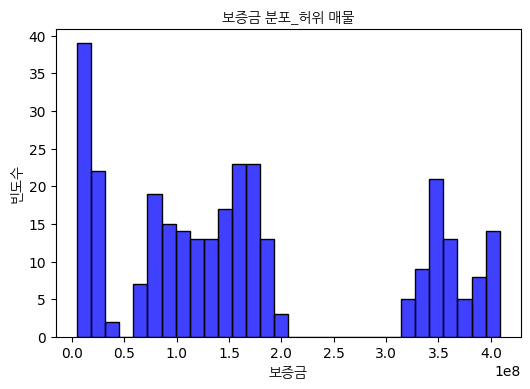

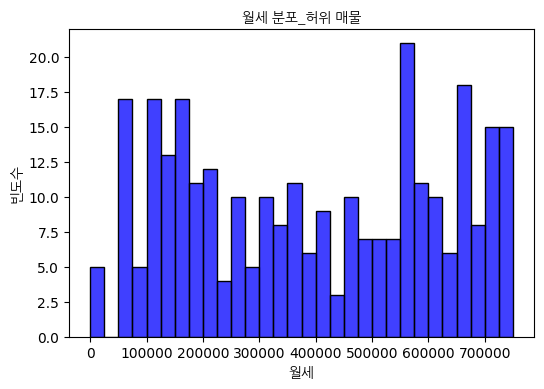

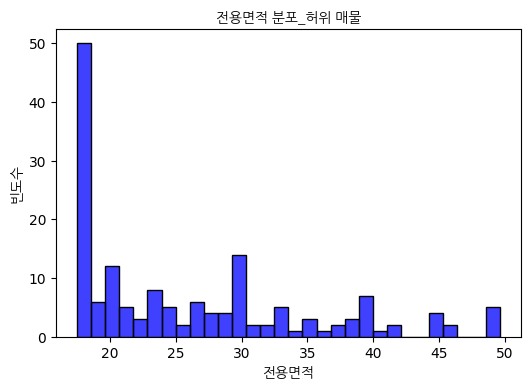

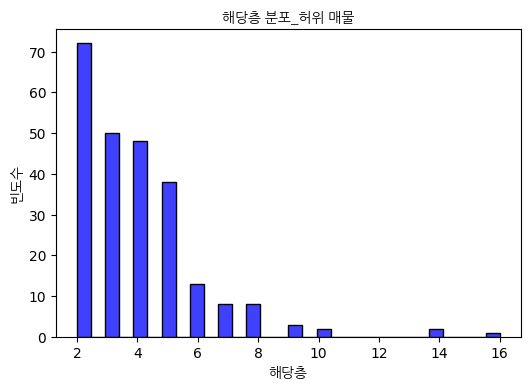

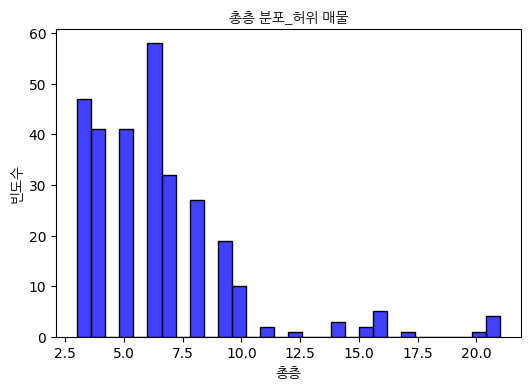

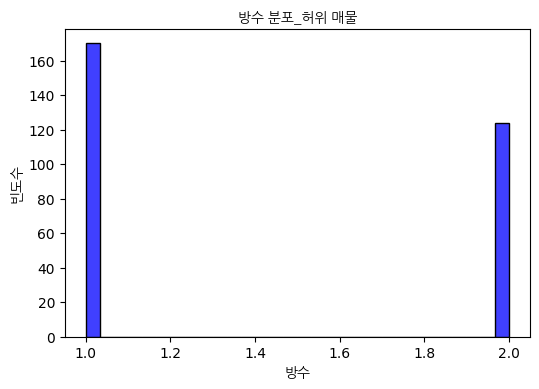

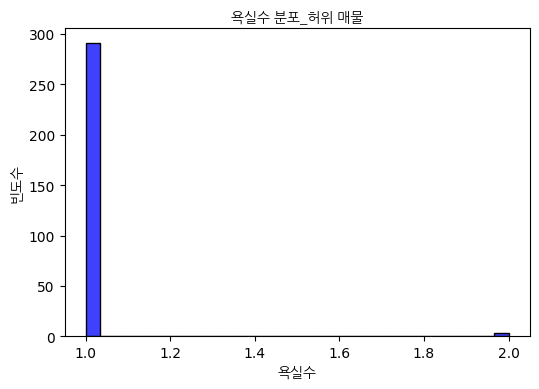

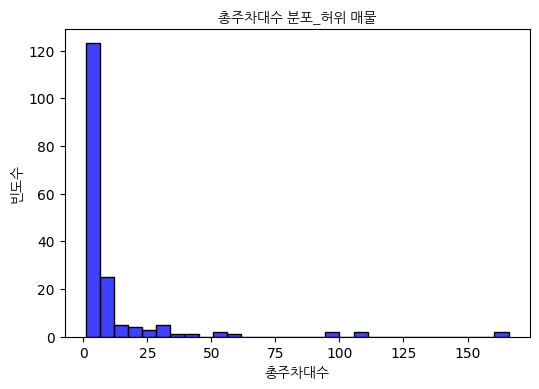

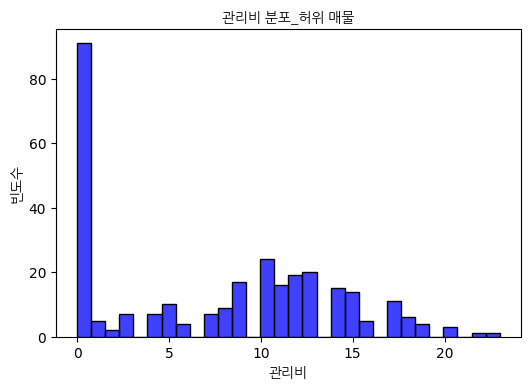

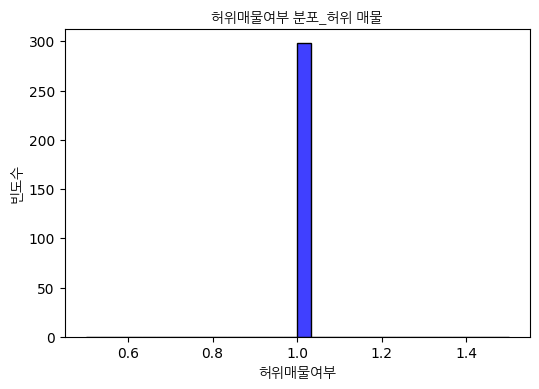

In [23]:
for col in numeric_columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(fake_train[col], kde=False, bins = 30, color="blue", edgecolor="black")
    plt.title(f"{col} 분포_허위 매물", fontproperties=fontprop)
    plt.xlabel(col, fontproperties=fontprop)
    plt.ylabel("빈도수", fontproperties=fontprop)
    plt.show()

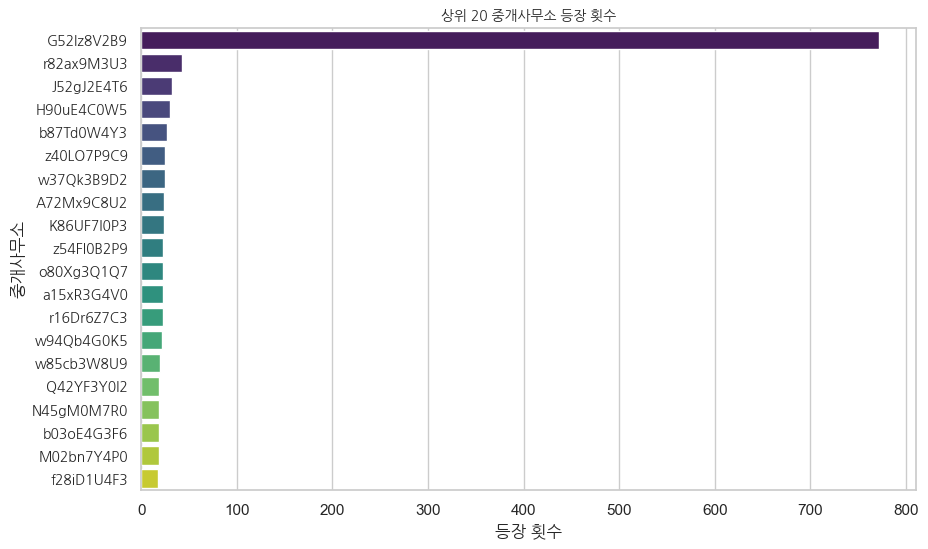

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# 📌 중개사무소 등장 횟수 계산
agency_counts = train["중개사무소"].value_counts()

# 📌 상위 N개 선택 (예: 20개)
top_n = 20
top_agencies = agency_counts.head(top_n)

# 📊 시각화: 중개사무소 등장 횟수
plt.figure(figsize=(10, 6))
sns.barplot(y=top_agencies.index, x=top_agencies.values, palette="viridis")

# 📌 제목 및 축 라벨 (폰트 적용)
plt.title(f"상위 {top_n} 중개사무소 등장 횟수", fontsize=14, fontproperties=fontprop)
plt.xlabel("등장 횟수", fontsize=12, fontproperties=fontprop)
plt.ylabel("중개사무소", fontsize=12, fontproperties=fontprop)

# 📌 폰트 적용 (Y축 중개사무소 이름)
plt.yticks(fontproperties=fontprop, fontsize=10)

plt.show()

# 전처리

## 결측치 처리

### 결측치 데이터 EDA

- 결측치 제거 전략
    - 전용면적 전처리 -> 보증금 & 월세
        - 유사 매물 평균 대체 -> 유사 매물이라고 판단할 만한 근거가 많지가 않음
            - 생각 좀 해보면 변수들 중에서 ['총층', '방향', '총주차대수', '중개사무소', '제공플랫폼'] 등이 똑같으면 유사 매물(or 같은 매물)로 판단?
        - 보증금 & 월세 비율 활용 -> 이게 그나마 가장 가능성이 높아 보이는 방식인 듯
            - 보증금 & 월세 비율을 활용해서 클러스터링 하여 해당 클러스터의 mean값으로 채우기
        - 회귀 모델 사용 -> 다른 결측치들이 또 문제니 패스
    - 해당층 결측치 전처리 -> 보증금 & 월세
        - 총층의 중앙값으로 전처리? -> 음 그닥? 오류가 너무 많을 거 같은데
            - 그냥 해당층은 버릴까?
        - 아님, 월세 & 보증금 두 개만의 변수로 해당층을 예측해보고 ACC 85% 이상이 아니면 버리기로 하자
    - 총층 결측치 전처리 ->보증금 & 월세 & 중개사무소
        - 전용면적처럼 유사 매물의 평균으로 대체? (중개사무소가 같으면 가까이에 있는 매물일 것, 비슷한 건물들끼리 모여있을 수 있다는 가정하에 진행) -> 정확도가 떨어져 보임
        - 그냥 버리기에는 아까운게 총층이 클수록 (건물의 높이가 높을수록) 허위 매물일 확률이 떨어질 것 같은 느낌?
            - 대형건물로 가라 치는건 좀 힘들지 않을 까?
    - 방수 -> 보증금 & 월세 & 전용면적
        - 보증금 & 월세 & 전용면적으로 클러스터링하여 해당 클러스터의 최빈값으로 결측치 처리
            - 방수 결측치 o + 전용면적 결측치 o의 비율을 확인해보고 결정하자
    - 총주차대수
        - 총층 & 보증금 & 월세 & 중개사무소 클러스터링을 통해 평균값으로 결측치 처리
            - 총층 결측치 o + 총주차대수 결측치 o의 비율을 확인해보고 결정
        - 주차대수를 그냥 주차 가능 / 불가능 으로 파생 변수를 만들어도 될 것 같음

In [24]:
null_data = train[train.isnull().any(axis=1)]
print("널데이터 수 : ", len(null_data))

missing_data_dict = {}
non_missing_data_dict = {}

for column in train.columns:
    missing_data = train[train[column].isnull()]
    if not missing_data.empty:
        missing_data_dict[column] = missing_data
        # print(f"\n[{column}]에 결측치가 있는 데이터 샘플:")
        # print(missing_data.head(1))

for column in train.columns:
    non_missing_data = train[train[column].notnull()]  # 결측치가 없는 데이터 선택
    if not non_missing_data.empty:
        non_missing_data_dict[column] = non_missing_data
        # print(f"\n[{column}]에 결측치가 없는 데이터 샘플:")
        # print(non_missing_data.head(1))


print(" ")
print('결측치가 있는 변수들 :',missing_data_dict.keys())

for column in missing_data_dict.keys():
    print(f"\n {column}의 결측치 수 : ", len(missing_data_dict[f'{column}']))

널데이터 수 :  1178
 
결측치가 있는 변수들 : dict_keys(['전용면적', '해당층', '총층', '방수', '욕실수', '총주차대수'])

 전용면적의 결측치 수 :  787

 해당층의 결측치 수 :  229

 총층의 결측치 수 :  16

 방수의 결측치 수 :  16

 욕실수의 결측치 수 :  18

 총주차대수의 결측치 수 :  696


In [25]:
fake_train[fake_train['총주차대수'].isna()]['주차가능여부'].value_counts()
# 총주차대수가 결측치인 경우 주차가능 여부가 불가능인 경우가 많음 -> 총주차대수를 drop

주차가능여부
불가능    114
가능       8
Name: count, dtype: int64

In [26]:
for column, missing_data in missing_data_dict.items():
    # 허위 매물 수 계산
    num_false_listings = missing_data[missing_data['허위매물여부'] == 1].shape[0]
    
    # 전체 결측치 데이터 수
    total_missing_data = missing_data.shape[0]
    
    # 허위 매물 비율 계산
    false_listing_ratio = num_false_listings / total_missing_data * 100 if total_missing_data > 0 else 0
    
    # 결과 출력
    print(f"[{column}] 결측치 데이터:")
    print(f" - 허위 매물 수: {num_false_listings}")
    print(f" - 허위 매물 비율: {false_listing_ratio:.2f}%")
    print("-" * 50)

[전용면적] 결측치 데이터:
 - 허위 매물 수: 139
 - 허위 매물 비율: 17.66%
--------------------------------------------------
[해당층] 결측치 데이터:
 - 허위 매물 수: 53
 - 허위 매물 비율: 23.14%
--------------------------------------------------
[총층] 결측치 데이터:
 - 허위 매물 수: 4
 - 허위 매물 비율: 25.00%
--------------------------------------------------
[방수] 결측치 데이터:
 - 허위 매물 수: 4
 - 허위 매물 비율: 25.00%
--------------------------------------------------
[욕실수] 결측치 데이터:
 - 허위 매물 수: 4
 - 허위 매물 비율: 22.22%
--------------------------------------------------
[총주차대수] 결측치 데이터:
 - 허위 매물 수: 122
 - 허위 매물 비율: 17.53%
--------------------------------------------------


In [27]:
def fill_missing_with_cosine_similarity_using_dicts(train, missing_data_dict, non_missing_data_dict, feature_columns, top_n=5):
    """
    결측치를 코사인 유사도를 활용하여 채우는 함수.
    기존에 생성된 missing_data_dict와 non_missing_data_dict을 활용.
    
    Parameters:
    - train: 원본 DataFrame
    - missing_data_dict: 결측치가 있는 데이터 딕셔너리
    - non_missing_data_dict: 결측치가 없는 데이터 딕셔너리
    - feature_columns: 유사도를 계산할 피처들의 컬럼명 리스트
    - top_n: 유사도 상위 N개의 평균으로 채움

    Returns:
    - 결측치가 채워진 DataFrame
    """
    df_filled = train.copy()

    for column in missing_data_dict.keys():
        print(f"Processing missing values for [{column}]...")
        
        # 결측치가 있는 데이터
        missing_data = missing_data_dict[column]

        # 결측치가 없는 데이터
        if column in non_missing_data_dict:
            non_missing_data = non_missing_data_dict[column]

            for idx in missing_data.index:
                # 결측치가 있는 행의 피처 값
                current_row = missing_data.loc[idx, feature_columns].values.reshape(1, -1)

                # 결측치가 없는 데이터의 피처 값
                complete_features = non_missing_data[feature_columns].values

                # 코사인 유사도 계산
                similarities = cosine_similarity(current_row, complete_features).flatten()

                # 상위 N개 선택
                top_n_indices = np.argsort(similarities)[-top_n:]
                top_n_values = non_missing_data.iloc[top_n_indices][column]

                # 결측치 채우기 (평균)
                df_filled.at[idx, column] = top_n_values.mean()

    return df_filled

# 파라미터 설정
feature_columns = ['총층', '방향', '총주차대수', '중개사무소', '제공플랫폼']

# 결측치 처리
train_filled = fill_missing_with_cosine_similarity_using_dicts(
    train, 
    missing_data_dict, 
    non_missing_data_dict, 
    feature_columns
)

# 결과 확인
print(train_filled.head())

Processing missing values for [전용면적]...


ValueError: could not convert string to float: '서향'

## 시계열 분석 (Target : 0/1)

허위매물여부
0    2154
1     298
Name: count, dtype: int64


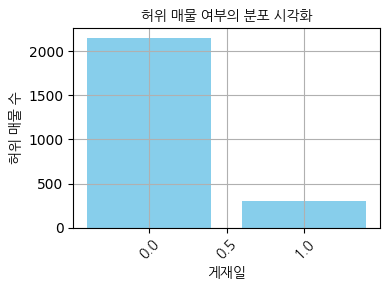

In [28]:
bar_data = train['허위매물여부'].value_counts()
print(bar_data)
plt.figure(figsize=(4, 3))
plt.bar(bar_data.index, bar_data.values, color='skyblue')
plt.title("허위 매물 여부의 분포 시각화", fontsize=12, fontproperties=fontprop)
plt.xlabel("게재일", fontsize=10, fontproperties=fontprop)
plt.ylabel("허위 매물 수", fontsize=10, fontproperties=fontprop)
plt.grid(True)
plt.xticks(rotation=45, fontproperties=fontprop)
plt.tight_layout()
plt.show()

In [29]:
# 게재일을 datetime 형태로 변환
train['게재일'] = pd.to_datetime(train['게재일'])

# 허위매물여부가 1인 데이터만 필터링
fraudulent_listings = train[train['허위매물여부'] == 1]

# 게재일별 허위 매물 수 집계
time_series = fraudulent_listings['게재일'].value_counts().sort_index()

# time_series를 데이터프레임으로 변환
time_series = time_series.reset_index()
time_series.columns = ['게재일', '허위 매물 수']  # 열 이름 변경

# 게재일을 datetime으로 변환
time_series['게재일'] = pd.to_datetime(time_series['게재일'])

# 월별 데이터 생성
time_series["게재월"] = time_series["게재일"].dt.to_period("M")
monthly_data = time_series.groupby("게재월")["허위 매물 수"].sum().reset_index()

# 분기별 데이터 생성
time_series["게재분기"] = time_series["게재일"].dt.to_period("Q")
quarterly_data = time_series.groupby("게재분기")["허위 매물 수"].sum().reset_index()

# 결과 확인
print("Time Series Data:")
print(time_series)

print("\nMonthly Data:")
print(monthly_data)

print("\nQuarterly Data:")
print(quarterly_data)

Time Series Data:
           게재일  허위 매물 수      게재월    게재분기
0   2023-04-28        1  2023-04  2023Q2
1   2023-05-09        1  2023-05  2023Q2
2   2023-06-09        1  2023-06  2023Q2
3   2023-06-21        1  2023-06  2023Q2
4   2023-06-23        1  2023-06  2023Q2
..         ...      ...      ...     ...
198 2024-09-23        1  2024-09  2024Q3
199 2024-09-24        1  2024-09  2024Q3
200 2024-10-06        1  2024-10  2024Q4
201 2024-10-08        2  2024-10  2024Q4
202 2024-11-23        1  2024-11  2024Q4

[203 rows x 4 columns]

Monthly Data:
        게재월  허위 매물 수
0   2023-04        1
1   2023-05        1
2   2023-06        4
3   2023-07        3
4   2023-08       12
5   2023-09       11
6   2023-10       12
7   2023-11       16
8   2023-12       10
9   2024-01        8
10  2024-02        7
11  2024-03       31
12  2024-04       32
13  2024-05       42
14  2024-06       38
15  2024-07       36
16  2024-08       17
17  2024-09       13
18  2024-10        3
19  2024-11        1

Quarterly

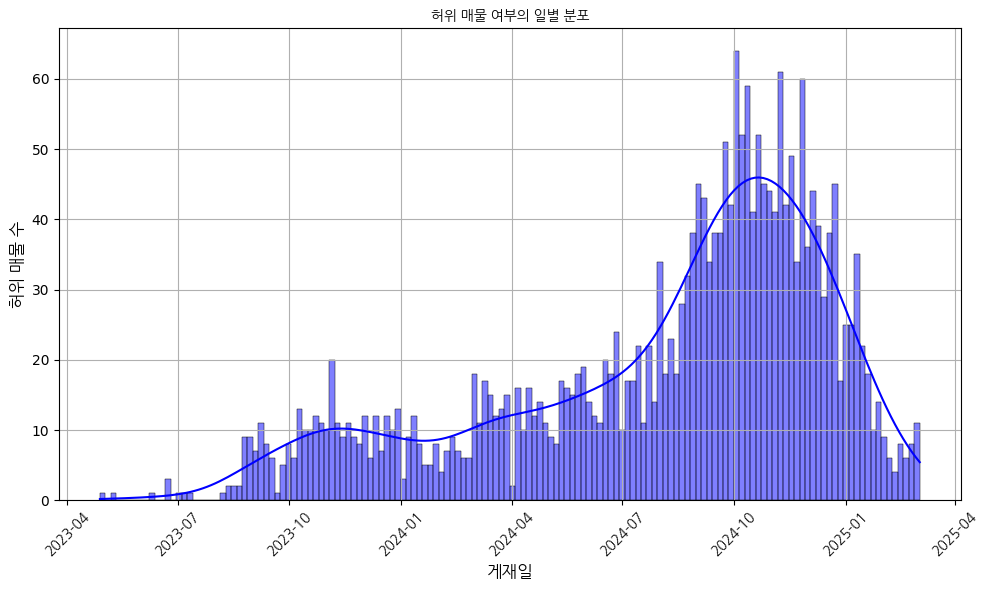

In [30]:
# 일별 시각화
plt.figure(figsize=(10, 6))
sns.histplot(data=train, x="게재일", kde=True, color="blue", bins=150, edgecolor="k")
plt.title("허위 매물 여부의 일별 분포", fontsize=14, fontproperties=fontprop)
plt.xlabel("게재일", fontsize=12, fontproperties=fontprop)
plt.ylabel("허위 매물 수", fontsize=12, fontproperties=fontprop)
plt.grid(True)
plt.xticks(rotation=45, fontproperties=fontprop)
plt.tight_layout()
plt.show()

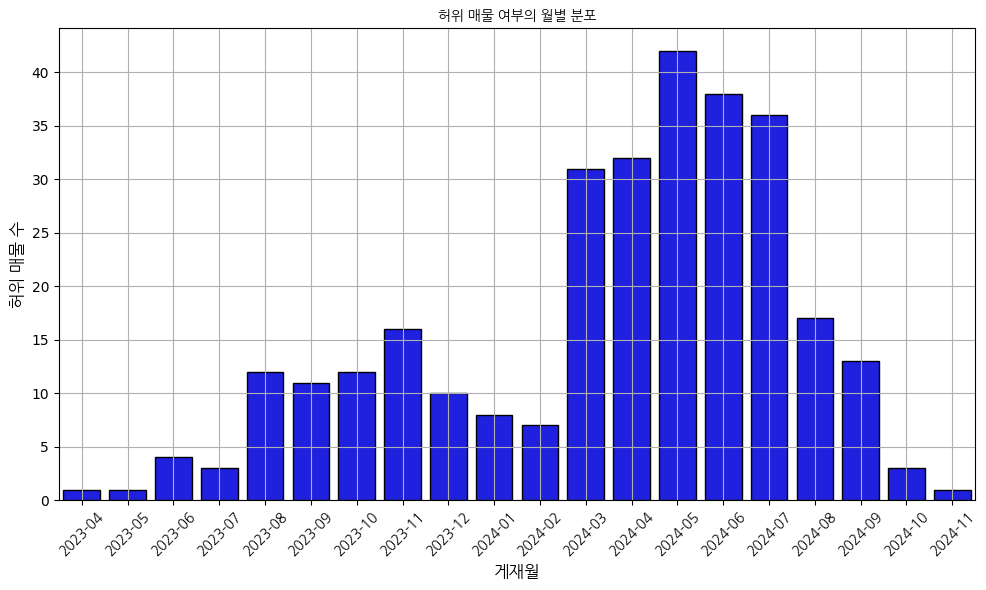

In [31]:
# 월별 시각화
plt.figure(figsize=(10, 6))
sns.barplot(data=monthly_data, x="게재월", y="허위 매물 수", color="blue", edgecolor="k")
plt.title("허위 매물 여부의 월별 분포", fontsize=14, fontproperties=fontprop)
plt.xlabel("게재월", fontsize=12, fontproperties=fontprop)
plt.ylabel("허위 매물 수", fontsize=12, fontproperties=fontprop)
plt.grid(True)
plt.xticks(rotation=45, fontproperties=fontprop)
plt.tight_layout()
plt.show()

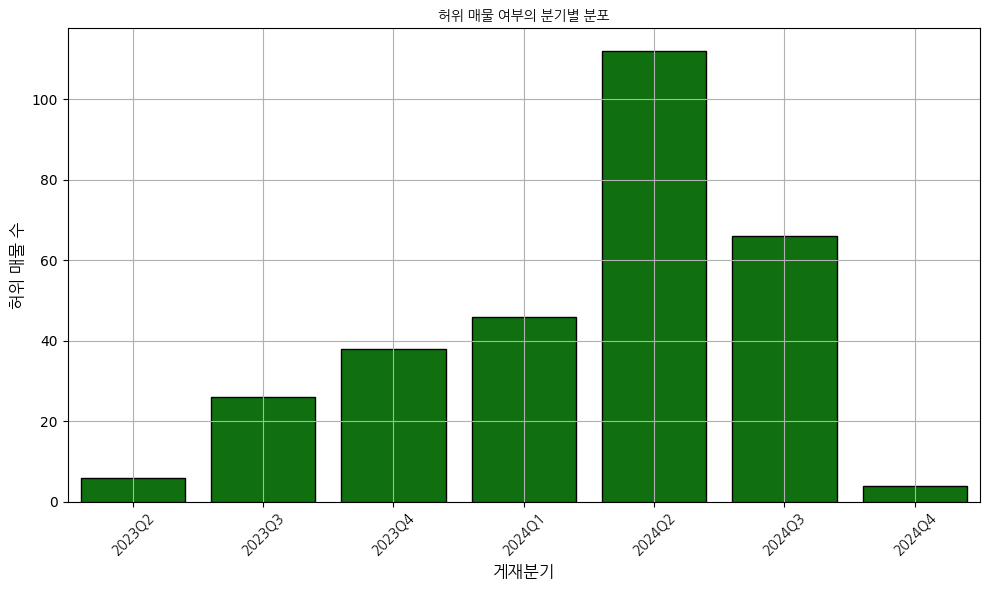

In [32]:
# 분기별 시각화
plt.figure(figsize=(10, 6))
sns.barplot(data=quarterly_data, x="게재분기", y="허위 매물 수", color="green", edgecolor="k")
plt.title("허위 매물 여부의 분기별 분포", fontsize=14, fontproperties=fontprop)
plt.xlabel("게재분기", fontsize=12, fontproperties=fontprop)
plt.ylabel("허위 매물 수", fontsize=12, fontproperties=fontprop)
plt.grid(True)
plt.xticks(rotation=45, fontproperties=fontprop)
plt.tight_layout()
plt.show()

# 시계열 분석 도메인 분석 및 인사이트 도출

---

## 1. 규제지역 해제
- 2024년 초 서울 대부분 지역이 규제지역에서 해제됨
- 규제지역 해제는 부동산 매매 활성화를 촉진, 투자 수요를 증가시킬 수 있음

### 허위 매물에 미치는 영향
- **허위 매물 증가 가능성**:
  - 규제 완화로 매수 심리가 개선되고 거래가 활성화되면, 매도자나 중개업자들이 허위 매물을 통해 더 많은 관심을 끌려는 시도가 늘어날 수 있음
    - 특히, 투자자들이 규제 해제 지역에서 투자 기회를 찾으려는 상황에서 허위 매물이 증가할 가능성이 큼
- **허위 매물 경쟁 심화**:
  - 해제된 지역에서 경쟁이 치열해지면, 거래를 유도하기 위해 존재하지 않는 매물을 등록하는 사례가 늘어날 수 있음

---

## 2. 2024년 공시 주택 가격 발표
- 공시 주택 가격은 세금과 직접적으로 연관되어 보유세 부담이 완화되거나 양극화가 심화될 가능성이 있음

### 허위 매물에 미치는 영향
- **고가 주택 허위 매물 증가 가능성**:
  - 공시가격 하락으로 고가 주택의 실질적 비용이 줄어들면, 고가 주택 매물에 대한 관심이 증가 -> 이를 이용해 허위 고가 매물을 올리는 사례가 늘어날 수 있음
- **저가 주택 허위 매물 증가 가능성**:
  - 공시가격 상승으로 세금 부담이 늘어나 매도 의지가 줄어드는 상황에서 중개업자들이 허위 저가 매물을 활용해 거래를 유도하려 할 수 있음

---

## 3. 부동산 규제 및 제도 변경
- 2024년에는 다음과 같은 규제가 예정 :
  - LTV(주택담보인정비율) 및 DTI(총부채상환비율) 규제가 강화
  - 고가 주택에 대한 종합부동산세율 상승

### 허위 매물에 미치는 영향
- **허위 매물 감소 가능성**:
  - 규제가 강화되면 거래량 자체가 줄어들 가능성이 있으므로, 허위 매물의 필요성이 낮아질 수 있음
  - 대출 규제 강화로 인해 실수요자만 시장에 남을 경우, 허위 매물을 통한 거래 유도 효과가 감소할 수 있음
- **허위 매물 증가 가능성**:
  - 매도자나 중개업자들이 규제로 인해 매수자를 유치하기 어려운 상황에서 허위 매물을 통해 거래를 유도하려 할 수 있음

---

## 전반적인 분석
- **규제 완화**: 허위 매물 **증가 요인**이 될 가능성이 큼
  - 매수 심리 개선과 거래 활성화가 허위 매물 등록 동기를 강화할 수 있음
- **규제 강화**: 허위 매물에 **감소 요인**이 될 가능성이 있음
  - 거래 감소로 허위 매물이 줄어들 수 있지만, 거래 유도를 위해 허위 매물이 증가할 가능성도 있음
- **공시 주택 가격 변화**: 
  - 고가 및 저가 주택 시장 모두에 영향을 미치며, **특정 가격대**에서 허위 매물이 **집중적으로 증가**할 가능성을 고려해야 함

---

## 추가 분석 제안
1. **상관관계 분석**:
   - 허위 매물 빈도와 다른 변수(예: 지역, 가격대, 플랫폼 등) 간의 관계를 확인하여 구체적인 요인을 탐구.
2. **시간별 집계**:
   - 일별보다는 **월별**, **분기별** 집계를 통해 장기적인 패턴을 더 명확히 분석.
3. **이벤트 데이터 추가**:
   - 부동산 관련 정부 정책이나 이벤트(예: 부동산 규제 발표, 신규 단지 분양 등)를 데이터에 추가하여 허위 매물의 증감 원인을 분석.

---

## 결론
허위 매물의 증감은 단일 요인에 의해서가 아니라, 다양한 시장 요인의 상호작용에 의해 결정됩니다. **규제 완화**는 **허위 매물 증가**의 주요 요인으로 작용할 가능성이 크며, **규제 강화**는 **허위 매물 감소**의 주요 요인으로 작용할 가능성이 있음   
-> **월별 & 분기별으로 분리 및 전처리 하여 EDA 할 필요가 있음**


In [33]:
train.head()

,ID,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,게재일,허위매물여부
0,TRAIN_0000,현장확인,402500000.0,470000,NaN,NaN,15.0,서향,1.0,1.0,가능,40.0,96,t93Nt6I2I0,B플랫폼,2024-10-09,0
1,TRAIN_0001,현장확인,170500000.0,200000,NaN,3.0,4.0,남동향,2.0,1.0,불가능,NaN,0,q39iV5J4E6,D플랫폼,2024-12-26,0
2,TRAIN_0002,전화확인,114000000.0,380000,NaN,2.0,3.0,동향,1.0,1.0,불가능,NaN,0,b03oE4G3F6,A플랫폼,2024-11-28,0
3,TRAIN_0003,현장확인,163500000.0,30000,36.3,3.0,9.0,남동향,2.0,1.0,가능,13.0,10,G52Iz8V2B9,A플랫폼,2024-11-26,0
4,TRAIN_0004,현장확인,346000000.0,530000,NaN,3.0,3.0,동향,2.0,1.0,불가능,NaN,0,N45gM0M7R0,B플랫폼,2024-06-25,1
